# Pipeline 5: Modeling interval mean amplitude

In [1]:
import os
import io
import logging
import warnings
import functools
import re
import datetime
import pprint as pp
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import fitgrid
import fitgrid.utils as fgutil

from udck19_filenames import (
    EEG_EPOCHS_DIR,  
    EEG_MODELING_DIR,
    EEG_MEASURES_DIR,
    PREPOCHS_TRMD_EEG_F,
)

from udck19_utils import (
    get_udck19_logger,
    check_ENV,
    N_EPOCH_SAMPS,  # epoch length in samples
    N_TRMD_EEG_EPOCHS,  # number of epochs after EEG screening in pipeline_1
    EEG_SCREEN_COL,  # HDF5 dataset key
    EEG_EXPT_SPECS,
    EEG_26_STREAMS,
    RHS_VARS,
    LMER_MODELS,
    check_epochs_shape, 
    standardize,
    fit_lmer_formulas,
    read_fg_summaries_hdf,
    udck19_figsave,
    panel_from_idx,
    FIG_TAG_SPECS,
    plotchans,
    get_symdiv_cmap_norm,
    CAP26_DF,
    MPL_32_CHAN, 
    MPL_MIDLINE
)

# enforce active conda env
check_ENV()

# logging config
__file__ = 'udck19_pipeline_5.ipynb'
logging.shutdown()
LOGGER = get_udck19_logger(__file__)

pipeline_start = datetime.datetime.now()

LOGGER.info(f"""
udck19 Supplementary Materials 5
CONDA_DEFAULT_ENV: {os.environ['CONDA_DEFAULT_ENV']}
pandas: {pd.__version__} 
fitgrid: {fitgrid.__version__}
Start {pipeline_start.strftime("%d.%b %Y %H:%M:%S")}
""")


udck19_pipeline_5.ipynb:INFO:
udck19 Supplementary Materials 5
CONDA_DEFAULT_ENV: udck19_pnas
pandas: 0.25.2 
fitgrid: 0.4.4
Start 02.Nov 2019 11:13:16



## Notebook globals

In [2]:
CHANLOCS_DF = pd.DataFrame.from_dict(MPL_32_CHAN['chanlocs'], orient='index', columns=['x', 'y'])
CHANLOCS_DF.index.names = ['channel']

FIG_PREFIX = "udck19_pipeline_5"
FIG_COUNT = 1

# single trial baseline, article, and noun interval mean amplitude measures
N4_ACZ_NCZ_MEASURES_F = EEG_MEASURES_DIR / "udck19_baseline_n4_interval_means.h5"

# interval measurement LMER model comparison summaries and AIC deltas
N4_LMER_ACZ_COMPS_F = "n4_lmer_acz_comps.h5"  

# Plotting utilities

In [3]:
# usual electrode locations plus reference, EOG, mastoids, and ground 
sph26_txt = io.StringIO(
"""
channel  phi   theta  ch_type
MiPf  90.0   90.0   eeg
LLPf  90.0  126.0   eeg
LLFr  90.0  162.0   eeg
LLTe  90.0  198.0   eeg
LLOc  90.0  234.0   eeg
MiOc  90.0  270.0   eeg
RLOc  90.0  306.0   eeg
RLTe  90.0  342.0   eeg
RLFr  90.0   18.0   eeg
RLPf  90.0   54.0   eeg
LMPf  59.0  108.0   eeg
LDFr  59.0  144.0   eeg
LDCe  59.0  180.0   eeg
LDPa  59.0  216.0   eeg
LMOc  59.0  252.0   eeg
RMOc  59.0  288.0   eeg
RDPa  59.0  324.0   eeg
RDCe  59.0    0.0   eeg
RDFr  59.0   36.0   eeg
RMPf  59.0   72.0   eeg
LMFr  26.0  126.0   eeg
LMCe  26.0  198.0   eeg
MiPa  26.0  270.0   eeg
RMCe  26.0  342.0   eeg
RMFr  26.0   54.0   eeg
MiCe   0.0    0.0   eeg

A1    130.0  205.0  ref
A2    130.0  335.0  ref

lle   140.0  120.0  eog
rle   140.0   60.0  eog

lhz   108.0  130.0  eog
rhz   108.0   50.0  eog

nasion 108.0   90.0  fid
lpa    108.0  180.0  fid
rpa    108.0    0.0  fid

gnd     72.0    90.0 gnd

"""
)

def sph2cart(row):
    label, phi, theta, r, ch_type = [*row] 
    
    deg2rad = 2 * np.pi / 360
    phi *= deg2rad
    theta *= deg2rad
    
    x = np.cos(theta) *  np.sin(phi)
    y = np.sin(theta) *  np.sin(phi)
    z = np.cos(phi) 
    
    # normalized to circle of radius 1
    lambert_x = x * np.sqrt(1 / (1 + z))  
    lambert_y = y  * np.sqrt(1 / (1 + z)) 
    
    row['x'], row['y'], row['z'] = x, y, z 
    row['x_lambert'], row['y_lambert'] = lambert_x, lambert_y
    
    return row
    
cap26 = pd.read_csv(sph26_txt, sep=r"\s+", engine='python')
sph26_txt.close()
cap26['r'] = 5  # radius
CAP26_DF = cap26.apply(lambda x: sph2cart(x), 1).set_index('channel')


def get_symdiv_cmap_norm(cmap, lower, upper, n_shades):
    
    # n_shades in each half of the symmetric color bar
    if lower != -upper:
        msg = f"upper and lower bounds must be symmetric around zero"
        raise ValueError(msg)

    n_colors = (2 * n_shades) + 1 # odd ncolors always odd so we have a white band at 0
    bounds = np.linspace(lower, upper, n_colors + 1)
    norm = mpl.colors.BoundaryNorm(bounds, n_colors)
    
    # get blue-white-red divergent colormap
    cmap = mpl.cm.get_cmap(cmap, n_colors)
    return cmap, norm



# Load single trial epochs and standardize cloze

As in pipeline_2

In [4]:
LOGGER.info(f"Loading prepared and artifact screened epochs: {PREPOCHS_TRMD_EEG_F}")
prepochs_trmd_eeg_df = pd.read_hdf(
    PREPOCHS_TRMD_EEG_F, EEG_SCREEN_COL, mode='r'
).reset_index().set_index(["Epoch_idx", "Time"])

# sanity check single trial epochs as screened in pipeline_1
assert (N_EPOCH_SAMPS, N_TRMD_EEG_EPOCHS) == check_epochs_shape(prepochs_trmd_eeg_df)
assert all([val == 'accept' for val in prepochs_trmd_eeg_df[EEG_SCREEN_COL]])

# standardize cloze values
prepochs_trmd_eeg_df, prepochs_trmd_eeg_means_sds = standardize(
    prepochs_trmd_eeg_df,
    ['article_cloze', 'ART_noun_cloze', 'NA_noun_cloze', ]
)
assert all(
    col in prepochs_trmd_eeg_df.columns or col in prepochs_trmd_eeg_df.index.names
    for col in EEG_26_STREAMS + RHS_VARS
)

msg = f"""
Prepared epochs after dropping EEG artifacts
    timestamps: {N_EPOCH_SAMPS}, epochs {N_TRMD_EEG_EPOCHS}
    index names: {prepochs_trmd_eeg_df.index.names}
    columns: {prepochs_trmd_eeg_df.columns}
    means and sds: {prepochs_trmd_eeg_means_sds}")
"""
LOGGER.info(msg)


LOGGER.info(prepochs_trmd_eeg_df.head())
LOGGER.info(prepochs_trmd_eeg_df.tail())

udck19_pipeline_5.ipynb:INFO:Loading prepared and artifact screened epochs: /mnt/cube/home/turbach/papers/udck19/analysis/data/epochs/prepochs_trimd_eeg.h5
udck19_pipeline_5.ipynb:INFO:
Prepared epochs after dropping EEG artifacts
    timestamps: 375, epochs 12043
    index names: ['Epoch_idx', 'Time']
    columns: Index(['expt', 'sub_id', 'item_id', 'h5_dataset', 'dataset_index',
       'event_code', 'regex_match', 'regex_anchor', 'garv_reject', 'article',
       'adjective', 'noun', 'article_cloze', 'ART_noun_cloze', 'NA_noun_cloze',
       'lle', 'lhz', 'MiPf', 'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr',
       'LLFr', 'RLFr', 'LMFr', 'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe',
       'RDCe', 'LDPa', 'RDPa', 'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc',
       'MiOc', 'A2', 'HEOG', 'rle', 'rhz', 'article_item_id', 'ptp_excursion',
       'blocked', 'garv_blink', 'garv_screen', 'eeg_screen', 'article_cloze_z',
       'ART_noun_cloze_z', 'NA_noun_cloze_z'],
      dtype='obje

# LMER N400 mean amplitude interval x baseline

 Compute single trial interval mean amplitudes pre- and post-article onset

In [5]:
%%time
def averager(epochs_df):

    # interval data in milliseconds, up to, not including the next sample
    intervals = [
        (-500, -1), 
        (-100, -1),
        # (208, 527),  # article N4 200 - 500 nominal
        # (308, 527),  # article N4 300 - 500 nominal
        # (528 + 300, 528 + 520),  # noun N4 300 - 500 nominal
        (200, 500),  # article N4 200 - 500 nominal
        (300, 500),  # article N4 300 - 500 nominal
        (528 + 300, 528 + 500),  # noun N4 300 - 500 nominal
    ]

    averages = []
    for interval in intervals:
        start, stop = interval
        
        # calculate interval mean
        avg = (
            epochs_df.query(
                'Time >= @start and Time <= @stop'
              )
            .groupby('Epoch_idx')
            .mean()
        )
        
        # descriptive label
        avg['measure'] = re.sub(
            "\s+", "_", re.sub(r"[(,)]", "", f"mean_{interval}")
        )
                        
        # measure index mix is 0 for the interval averages and > 0 for 
        # post- minus pre-stim difference measures calculated next block
        avg['midx'] = int(0)
   
        avg.set_index(['measure', 'midx'], append=True, inplace=True)
        averages.append(avg)
        
    # calculate difference measures, each given by a pre-, post-stim 
    # interval pair.
    n_baselines = 2  # number of pre-stim baseline intervals 
    n_windows = len(averages) - n_baselines  # number of post-stim intervals
    measures = []
    for bidx, baseline in enumerate(averages[0:n_baselines]):
        for widx, window in enumerate(averages[n_baselines:]):
            
            # set measure tag and index 1, 2, 3, ... for this measurement pair
            win_tag = window.index.unique('measure')
            assert len(win_tag) == 1
            
            bl_tag = baseline.index.unique('measure')
            assert len(bl_tag) == 1
            
            measure_tag = f"{win_tag[0]}_sub_{bl_tag[0]}"
            midx = int((bidx * n_windows) + widx + 1)
            
            # strip dataframe index down to Epoch_idx for the calculation 
            measure = window.reset_index(['measure', 'midx'], drop=True).sub(
                baseline.reset_index(['measure', 'midx'], drop=True)
            )

            # set indices for the new measure
            measure['measure'], measure['midx'] = measure_tag, midx
            measure.set_index(['measure', 'midx'], inplace=True, append=True)
            measures.append(measure)
    
    # retain the interval averages along with the measures
    return pd.concat(
        averages + measures, axis=0
    ).sort_index(
        axis=0, level=['Epoch_idx', 'midx', 'measure']
    )


# compute interval means and measurements over single trial epochs
prepochs_trmd_eeg_avgs_df = averager(prepochs_trmd_eeg_df[EEG_26_STREAMS])

rhs_vars = prepochs_trmd_eeg_df.query('Time == 0')[RHS_VARS]
rhs_vars.index = rhs_vars.index.remove_unused_levels()

### merge in the RHS predictors at the article event
prepochs_trmd_eeg_avgs_df = prepochs_trmd_eeg_avgs_df.merge(
    rhs_vars, 
    how='inner',
    left_index=True,
    right_index=True,
    sort=False,
)

# Drop the Time == 0 time stamp and rename the measurement index to 'Time' for summaries
prepochs_trmd_eeg_avgs_df = prepochs_trmd_eeg_avgs_df.reset_index('Time', drop=True)
prepochs_trmd_eeg_avgs_df.rename_axis(index={'midx': 'Time'}, inplace=True)

display(prepochs_trmd_eeg_avgs_df.head(24))

# overwrite
prepochs_trmd_eeg_avgs_df.to_hdf(
    N4_ACZ_NCZ_MEASURES_F, key='interval_means_measures', mode='w'
)

RLPf      RMPf       RDFr  \
Epoch_idx measure                        Time                                  
10000     mean_-100_-1                   0    -2.158936  1.517881  -1.043800   
          mean_-500_-1                   0    -1.074207 -1.159749  -0.486608   
          mean_200_500                   0     0.306813  0.669540  -4.920952   
          mean_300_500                   0    -0.776726 -1.107721  -6.541365   
          mean_828_1028                  0    -1.573069 -0.106502  -2.127634   
          mean_200_500_sub_mean_-500_-1  1     1.381020  1.829289  -4.434344   
          mean_300_500_sub_mean_-500_-1  2     0.297481  0.052027  -6.054757   
          mean_828_1028_sub_mean_-500_-1 3    -0.498862  1.053247  -1.641027   
          mean_200_500_sub_mean_-100_-1  4     2.465749 -0.848341  -3.877151   
          mean_300_500_sub_mean_-100_-1  5     1.382209 -2.625603  -5.497564   
          mean_828_1028_sub_mean_-100_-1 6     0.585867 -1.624383  -1.083834   
10001     mean_-100_-1                   0    -1.759093 -3.955495  -5.783083   
          mean_-500_-1                   0    -0.372094  0.540757   0.882568   
          mean_200_500                   0    -0.454666 -4.563649  -8.790671   
          mean_300_500                   0    -1.558401 -5.853895 -10.433196   
          mean_828_1028                  0    -4.414050 -0.136094  -5.544371   
          mean_200_500_sub_mean_-500_-1  1    -0.082572 -5.104407  -9.673239   
          mean_300_500_sub_mean_-500_-1  2    -1.186307 -6.394652 -11.315765   
          mean_828_1028_sub_mean_-500_-1 3    -4.041957 -0.676852  -6.426939   
          mean_200_500_sub_mean_-100_-1  4     1.304427 -0.608155  -3.007587   
          mean_300_500_sub_mean_-100_-1  5     0.200692 -1.898400  -4.650113   
          mean_828_1028_sub_mean_-100_-1 6    -2.654957  3.819400   0.238712   
10002     mean_-100_-1                   0    -7.900045 -4.164539  -4.808487   
          mean_-500_-1                   0    -1.937206 -0.752123  -1.345419   

                                                   RLFr       RMFr       RMCe  \
Epoch_idx measure                        Time                                   
10000     mean_-100_-1                   0     0.326221   0.819421  -2.829614   
          mean_-500_-1                   0     0.052963  -0.369796  -2.426599   
          mean_200_500                   0    -2.392286  -9.096109 -12.922156   
          mean_300_500                   0    -3.804367 -11.049092 -14.654590   
          mean_828_1028                  0    -4.892995  -7.007015  -9.720442   
          mean_200_500_sub_mean_-500_-1  1    -2.445249  -8.726313 -10.495557   
          mean_300_500_sub_mean_-500_-1  2    -3.857330 -10.679296 -12.227991   
          mean_828_1028_sub_mean_-500_-1 3    -4.945958  -6.637219  -7.293843   
          mean_200_500_sub_mean_-100_-1  4    -2.718507  -9.915530 -10.092542   
          mean_300_500_sub_mean_-100_-1  5    -4.130588 -11.868514 -11.824976   
          mean_828_1028_sub_mean_-100_-1 6    -5.219216  -7.826436  -6.890828   
10001     mean_-100_-1                   0    -2.262801  -7.628723  -8.340392   
          mean_-500_-1                   0     0.290954   0.467031  -0.074585   
          mean_200_500                   0    -3.398610  -8.474309  -9.038782   
          mean_300_500                   0    -4.612574  -9.599180 -10.337833   
          mean_828_1028                  0    -5.122836  -0.406248   1.612222   
          mean_200_500_sub_mean_-500_-1  1    -3.689564  -8.941340  -8.964197   
          mean_300_500_sub_mean_-500_-1  2    -4.903528 -10.066211 -10.263248   
          mean_828_1028_sub_mean_-500_-1 3    -5.413790  -0.873279   1.686807   
          mean_200_500_sub_mean_-100_-1  4    -1.135809  -0.845585  -0.698389   
          mean_300_500_sub_mean_-100_-1  5    -2.349773  -1.970456  -1.997441   
          mean_828_1028_sub_mean_-100_-1 6    -2.860035   7.222475   9.952614   
10002     mean_-100_-1    

CPU times: user 57.1 s, sys: 17.3 s, total: 1min 14s
Wall time: 5.03 s


# LMER model mean article and noun N4s

From here we could break out to R, import the N4 measures x channels dataframe and run `lme4:lmer` in R.

Instead we trick fitgrid into batch processing the models all in one go by telling it that the model index `midx=1, 2, 3, ...` is a "Time" stamp. 


In [6]:
# can read from the file, faster when debugging cells below
# prepochs_trmd_eeg_avgs_df = pd.read_hdf(n4_measures_f, 'interval_means_measures')

article_midxs = [1, 2, 4, 5]
article_n4_epochs_fg = fitgrid.epochs_from_dataframe(
    prepochs_trmd_eeg_avgs_df.query("Time in @article_midxs"),
    epoch_id="Epoch_idx",
    time='Time', # measurment indices are pseudo Time series 1, 2, 3 
    channels=EEG_26_STREAMS
)
article_n4_epochs_fg.table.shape
LOGGER.info(
    f"Number of article epochs:"
    f" {len(article_n4_epochs_fg.table.index.unique('Epoch_idx'))}"
)


udck19_pipeline_5.ipynb:INFO:Number of article epochs: 12043


In [7]:
NaN = np.nan
noun_midxs = [3, 6]
noun_n4_epochs_fg = fitgrid.epochs_from_dataframe(
    prepochs_trmd_eeg_avgs_df.loc[
        ~prepochs_trmd_eeg_avgs_df['ART_noun_cloze_z'].isna(), :  # this drops the adjective trials
    ].query("Time in @noun_midxs"),
    epoch_id="Epoch_idx",
    time='Time', # measurment indices are pseudo Time series 1, 2, 3 
    channels=EEG_26_STREAMS
)
LOGGER.info(
    f"Number of noun epochs (after dropping adjectives eeg_2):"
    f"{len(noun_n4_epochs_fg.table.index.unique('Epoch_idx'))}"
)


udck19_pipeline_5.ipynb:INFO:Number of noun epochs (after dropping adjectives eeg_2):10867


# check the measures and indexes for articles and nouns

In [8]:
def get_measure_time_idx(epochs_fg):
    for idx, (epoch_idx, epoch) in enumerate(epochs_fg.table.groupby('Epoch_idx')):
        if idx == 0:
            measure_time = epoch[['measure', 'Time', ]]
    assert all(measure_time.to_numpy().flatten() == epoch[['measure', 'Time']].to_numpy().flatten())
    return measure_time.reset_index('Epoch_idx', drop=True)

article_measure_time_idxs = get_measure_time_idx(article_n4_epochs_fg)
article_measure_time_idxs['probe'] = 'article'

assert all(
    [
        re.match(r"mean_[23]00_500_sub_mean_-[15]00_-1", measure) is not None
        for measure in article_measure_time_idxs['measure']
    ]
)

LOGGER.info(f"""
Article measure-time indexs:{article_measure_time_idxs}
""")

noun_measure_time_idxs = get_measure_time_idx(noun_n4_epochs_fg)
noun_measure_time_idxs['probe'] = 'noun'
assert all(
    [
        re.match(r"mean_828_1028_sub_mean_-[15]00_-1", measure) is not None
        for measure in noun_measure_time_idxs['measure']
    ]
)
LOGGER.info(f"""
Noun measure-time indexs: {noun_measure_time_idxs}
""")

measure_time_idxs = pd.concat(
    [article_measure_time_idxs, noun_measure_time_idxs]
).reset_index()
LOGGER.info(f"""
All measure-time indexs: {measure_time_idxs}
""")

udck19_pipeline_5.ipynb:INFO:
Article measure-time indexs:                         measure  Time    probe
0  mean_200_500_sub_mean_-500_-1     1  article
1  mean_300_500_sub_mean_-500_-1     2  article
2  mean_200_500_sub_mean_-100_-1     4  article
3  mean_300_500_sub_mean_-100_-1     5  article

udck19_pipeline_5.ipynb:INFO:
Noun measure-time indexs:                           measure  Time probe
0  mean_828_1028_sub_mean_-500_-1     3  noun
1  mean_828_1028_sub_mean_-100_-1     6  noun

udck19_pipeline_5.ipynb:INFO:
All measure-time indexs:    index                         measure  Time    probe
0      0   mean_200_500_sub_mean_-500_-1     1  article
1      1   mean_300_500_sub_mean_-500_-1     2  article
2      2   mean_200_500_sub_mean_-100_-1     4  article
3      3   mean_300_500_sub_mean_-100_-1     5  article
4      0  mean_828_1028_sub_mean_-500_-1     3     noun
5      1  mean_828_1028_sub_mean_-100_-1     6     noun



In [9]:
n4_lmer_acz_comps = {

    'MAX': (
        'article_cloze_z + (article_cloze_z | expt) + (article_cloze_z | sub_id) + (article_cloze_z | article_item_id)',
        '(article_cloze_z | expt) + (article_cloze_z | sub_id) + (article_cloze_z | article_item_id)',
    ),
    
    'KIM': (
        'article_cloze_z + (1 | expt) + (article_cloze_z | sub_id) + (1 | article_item_id)',
        '(1 | expt) + (article_cloze_z | sub_id) + (1 | article_item_id)',
    ),
    
    'KIP': (
        'article_cloze_z + (1 | expt) + (1 | sub_id) + (1 | article_item_id)',
        '(1 | expt) + (1 | sub_id) + (1 | article_item_id)',
    ),
    
    'MAX_x_expt': (
        'expt + article_cloze_z + article_cloze_z:expt + (article_cloze_z | sub_id) + (article_cloze_z | article_item_id)',
        'expt + (article_cloze_z | sub_id) + (article_cloze_z | article_item_id)',
    ),
    
    'KIM_x_expt': (
        'expt + article_cloze_z + article_cloze_z:expt + (article_cloze_z | sub_id) + (1 | article_item_id)',
        'expt + (article_cloze_z | sub_id) + (1 | article_item_id)',
    ),

    'KIP_x_expt': (
        'expt + article_cloze_z + article_cloze_z:expt + (1 | sub_id) + (1 | article_item_id)',
        'expt + (1 | sub_id) + (1 | article_item_id)',
    ),
}


# generate the corresponding noun n4 model sets
nouns = {}
for key, val in n4_lmer_acz_comps.items():
    nouns[f"{key}_noun"] = tuple(
        formula.replace('article_cloze_z', 'ART_noun_cloze_z')
        .replace('article_item_id', 'item_id')
        for formula in val
      )
n4_lmer_acz_comps.update(nouns)

LOGGER.info(f"""
n4_lmer_acz_comps:
{pp.pformat(n4_lmer_acz_comps)}
""")


udck19_pipeline_5.ipynb:INFO:
n4_lmer_acz_comps:
{'KIM': ('article_cloze_z + (1 | expt) + (article_cloze_z | sub_id) + (1 | '
         'article_item_id)',
         '(1 | expt) + (article_cloze_z | sub_id) + (1 | article_item_id)'),
 'KIM_noun': ('ART_noun_cloze_z + (1 | expt) + (ART_noun_cloze_z | sub_id) + '
              '(1 | item_id)',
              '(1 | expt) + (ART_noun_cloze_z | sub_id) + (1 | item_id)'),
 'KIM_x_expt': ('expt + article_cloze_z + article_cloze_z:expt + '
                '(article_cloze_z | sub_id) + (1 | article_item_id)',
                'expt + (article_cloze_z | sub_id) + (1 | article_item_id)'),
 'KIM_x_expt_noun': ('expt + ART_noun_cloze_z + ART_noun_cloze_z:expt + '
                     '(ART_noun_cloze_z | sub_id) + (1 | item_id)',
                     'expt + (ART_noun_cloze_z | sub_id) + (1 | item_id)'),
 'KIP': ('article_cloze_z + (1 | expt) + (1 | sub_id) + (1 | article_item_id)',
         '(1 | expt) + (1 | sub_id) + (1 | article_item_id)'),
 'KIP_n

# Fit LMER models for the single-trial interval mean N4 measurements

In [10]:
%%time

n4_lmer_acz_comps_summaries = []
n4_lmer_acz_comps_AIC_deltas = []

for proc, models in n4_lmer_acz_comps.items():
    
    # supress pandas DeprecationWarning for rpy2 DataFrame.from_items
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # select the data set to model ... article or noun
        epochs_fg, critw = None, None
        if '_noun' in proc:
            epochs_fg = noun_n4_epochs_fg
            critw = 'noun'
        else:
            epochs_fg = article_n4_epochs_fg
            critw = 'article'

        LOGGER.info(f"Fitting {critw}\n{proc}:{pp.pformat(models)}")

        summary_long = fgutil.summary.summarize(
            epochs_fg,
            modeler='lmer',
            RHS=models,
            LHS=EEG_26_STREAMS,
            parallel=True,
            n_cores=8,
            REML=False
        )
        
    # calc and index the AIC deltas. Note this is a channels long format
    aic_deltas = fgutil.summary._get_AICs(summary_long)
    aic_deltas['proc'] = proc
    aic_deltas.set_index('proc', append=True, inplace=True)
    n4_lmer_acz_comps_AIC_deltas.append(aic_deltas)
    
    # index the summary likewise. Note this is the default summary channels wide format
    summary_long['proc'] = proc
    summary_long.set_index('proc', append=True, inplace=True)
    n4_lmer_acz_comps_summaries.append(summary_long)



udck19_pipeline_5.ipynb:INFO:Fitting article
MAX:('article_cloze_z + (article_cloze_z | expt) + (article_cloze_z | sub_id) + '
 '(article_cloze_z | article_item_id)',
 '(article_cloze_z | expt) + (article_cloze_z | sub_id) + (article_cloze_z | '
 'article_item_id)')
100%|██████████| 4/4 [00:01<00:00,  2.69it/s]
udck19_pipeline_5.ipynb:INFO:Fitting article
KIM:('article_cloze_z + (1 | expt) + (article_cloze_z | sub_id) + (1 | '
 'article_item_id)',
 '(1 | expt) + (article_cloze_z | sub_id) + (1 | article_item_id)')
100%|██████████| 4/4 [00:01<00:00,  3.11it/s]
udck19_pipeline_5.ipynb:INFO:Fitting article
KIP:('article_cloze_z + (1 | expt) + (1 | sub_id) + (1 | article_item_id)',
 '(1 | expt) + (1 | sub_id) + (1 | article_item_id)')
100%|██████████| 4/4 [00:01<00:00,  2.92it/s]
udck19_pipeline_5.ipynb:INFO:Fitting article
MAX_x_expt:('expt + article_cloze_z + article_cloze_z:expt + (article_cloze_z | sub_id) + '
 '(article_cloze_z | article_item_id)',
 'expt + (article_cloze_z | sub_id) 

CPU times: user 34.6 s, sys: 28.3 s, total: 1min 2s
Wall time: 1h 8min 34s


# Stack and decorate the AICs and LMER summaries for the interval measurements

In [11]:
n4_lmer_acz_comps_AIC_deltas_df = (
    pd.concat(n4_lmer_acz_comps_AIC_deltas, axis=0)
    .merge(
        measure_time_idxs,
        on='Time',
        how='inner',
        left_index=False,
        right_index=True,
    ).set_index(['measure', 'probe'], append=True)
)

n4_lmer_acz_comps_summaries_df = (
    pd.concat(n4_lmer_acz_comps_summaries, axis=0)
    .merge(
        measure_time_idxs,
        on='Time',
        how='inner',
        left_index=False,
        right_index=True,
    ).set_index(['measure', 'probe'], append=True)
)

In [12]:
display(n4_lmer_acz_comps_AIC_deltas_df.head())
display(n4_lmer_acz_comps_AIC_deltas_df.tail())

AIC  \
Time model                                              channel proc measure                       probe                   
1    article_cloze_z + (article_cloze_z | expt) + (a... RLPf    MAX  mean_200_500_sub_mean_-500_-1 article  84620.972106   
                                                        RMPf    MAX  mean_200_500_sub_mean_-500_-1 article  85367.191257   
                                                        RDFr    MAX  mean_200_500_sub_mean_-500_-1 article  83670.492781   
                                                        RLFr    MAX  mean_200_500_sub_mean_-500_-1 article  75568.118151   
                                                        RMFr    MAX  mean_200_500_sub_mean_-500_-1 article  85113.956603   

                                                                                                            has_warning  \
Time model                                              channel proc measure                       probe                  
1    article_cloze_z + (article_cloze_z | expt) + (a... RLPf    MAX  mean_200_500_sub_mean_-500_-1 article          1.0   
                                                        RMPf    MAX  mean_200_500_sub_mean_-500_-1 article          1.0   
                                                        RDFr    MAX  mean_200_500_sub_mean_-500_-1 article          0.0   
                                                        RLFr    MAX  mean_200_500_sub_mean_-500_-1 article          0.0   
                                                        RMFr    MAX  mean_200_500_sub_mean_-500_-1 article          1.0   

                                                                                                            min_delta  \
Time model                                              channel proc measure                       probe                
1    article_cloze_z + (article_cloze_z | expt) + (a... RLPf    MAX  mean_200_500_sub_mean_-500_-1 article   1.978213   
                                                        RMPf    MAX  mean_200_500_sub_mean_-500_-1 article   1.753246   
                                                        RDFr    MAX  mean_200_500_sub_mean_-500_-1 article   1.996405   
                                                        RLFr    MAX  mean_200_500_sub_mean_-500_-1 article   1.850462   
                                                        RMFr    MAX  mean_200_500_sub_mean_-500_-1 article   1.275127   

                                                                                                            index  
Time model                                              channel proc measure                       probe           
1    article_cloze_z + (article_cloze_z | expt) + (a... RLPf    MAX  mean_200_500_sub_mean_-500_-1 article      0  
                                                        RMPf    MAX  mean_200_500_sub_mean_-500_-1 article      0  
                                                        RDFr    MAX  mean_200_500_sub_mean_-500_-1 article      0  
                                                        RLFr    MAX  mean_200_500_sub_mean_-500_-1 article      0  
                                                        RMFr    MAX  mean_200_500_sub_mean_-500_-1 article      0

AIC  \
Time model                               channel proc            measure                        probe                 
6    expt + (1 | sub_id) + (1 | item_id) LDCe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   79806.750813   
                                         LDPa    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   80966.525576   
                                         LLTe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   73064.782594   
                                         LLOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   75623.025309   
                                         LMOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   82602.627845   

                                                                                                       has_warning  \
Time model                               channel proc            measure                        probe                
6    expt + (1 | sub_id) + (1 | item_id) LDCe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun           0.0   
                                         LDPa    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun           0.0   
                                         LLTe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun           0.0   
                                         LLOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun           0.0   
                                         LMOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun           0.0   

                                                                                                        min_delta  \
Time model                               channel proc            measure                        probe               
6    expt + (1 | sub_id) + (1 | item_id) LDCe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun    61.979885   
                                         LDPa    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   114.504623   
                                         LLTe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun    20.944594   
                                         LLOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   133.280485   
                                         LMOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun   145.858561   

                                                                                                       index  
Time model                               channel proc            measure                        probe         
6    expt + (1 | sub_id) + (1 | item_id) LDCe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun       1  
                                         LDPa    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun       1  
                                         LLTe    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun       1  
                                         LLOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun       1  
                                         LMOc    KIP_x_expt_noun mean_828_1028_sub_mean_-100_-1 noun       1

In [13]:
# save the summaries and AIC deltas

n4_lmer_acz_comps_AIC_deltas_df.to_hdf(
    EEG_MODELING_DIR / N4_LMER_ACZ_COMPS_F,
    key='aic_deltas',
    mode='w',
)

n4_lmer_acz_comps_summaries_df.to_hdf(
    EEG_MODELING_DIR / N4_LMER_ACZ_COMPS_F,
    key='summaries',
    mode='a',
)

In [14]:
# for debugging cells below
n4_lmer_acz_comps_AIC_deltas_df = pd.read_hdf(EEG_MODELING_DIR / N4_LMER_ACZ_COMPS_F, key='aic_deltas')
n4_lmer_acz_comps_summaries_df = pd.read_hdf(EEG_MODELING_DIR / N4_LMER_ACZ_COMPS_F, key='summaries')


# Mean amplitude AIC model comparisons

In [15]:
# ----------------
# figure kw params
# ----------------

# pasted from fitgrid.utils.summary.py::plot_AICmin_delta

# blues color blind friendly
# http://colorbrewer2.org/#type=sequential&scheme=Blues&n=5
pal = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']

aic_bands = [0, 2, 4, 7, 10]   # Burnham and Anderson, 2002

cmap_bands = aic_bands
cmap = mpl.colors.ListedColormap(pal)
cmap.set_over(color='#08306b')  # darkest blue from from Blues n=7
cmap.set_under(color='lightgray')
bounds = cmap_bands  # aic_min_delta_bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# panel label
panel_kws = dict(
        horizontalalignment='right',
        fontsize='x-large',
        fontweight='bold',
)

chan_label_kws = dict(
    horizontalalignment = 'center',
    verticalalignment = 'bottom',
    fontsize='large',
    color='gray'
)

marker_kws = dict(s=200, edgecolor='k', lw=0.5)
head_marker_kws = dict(s=75, edgecolor='gray', lw=.5,)
circ_kws =  dict(edgecolor='black', lw=0.5, facecolor='none', clip_on=False)

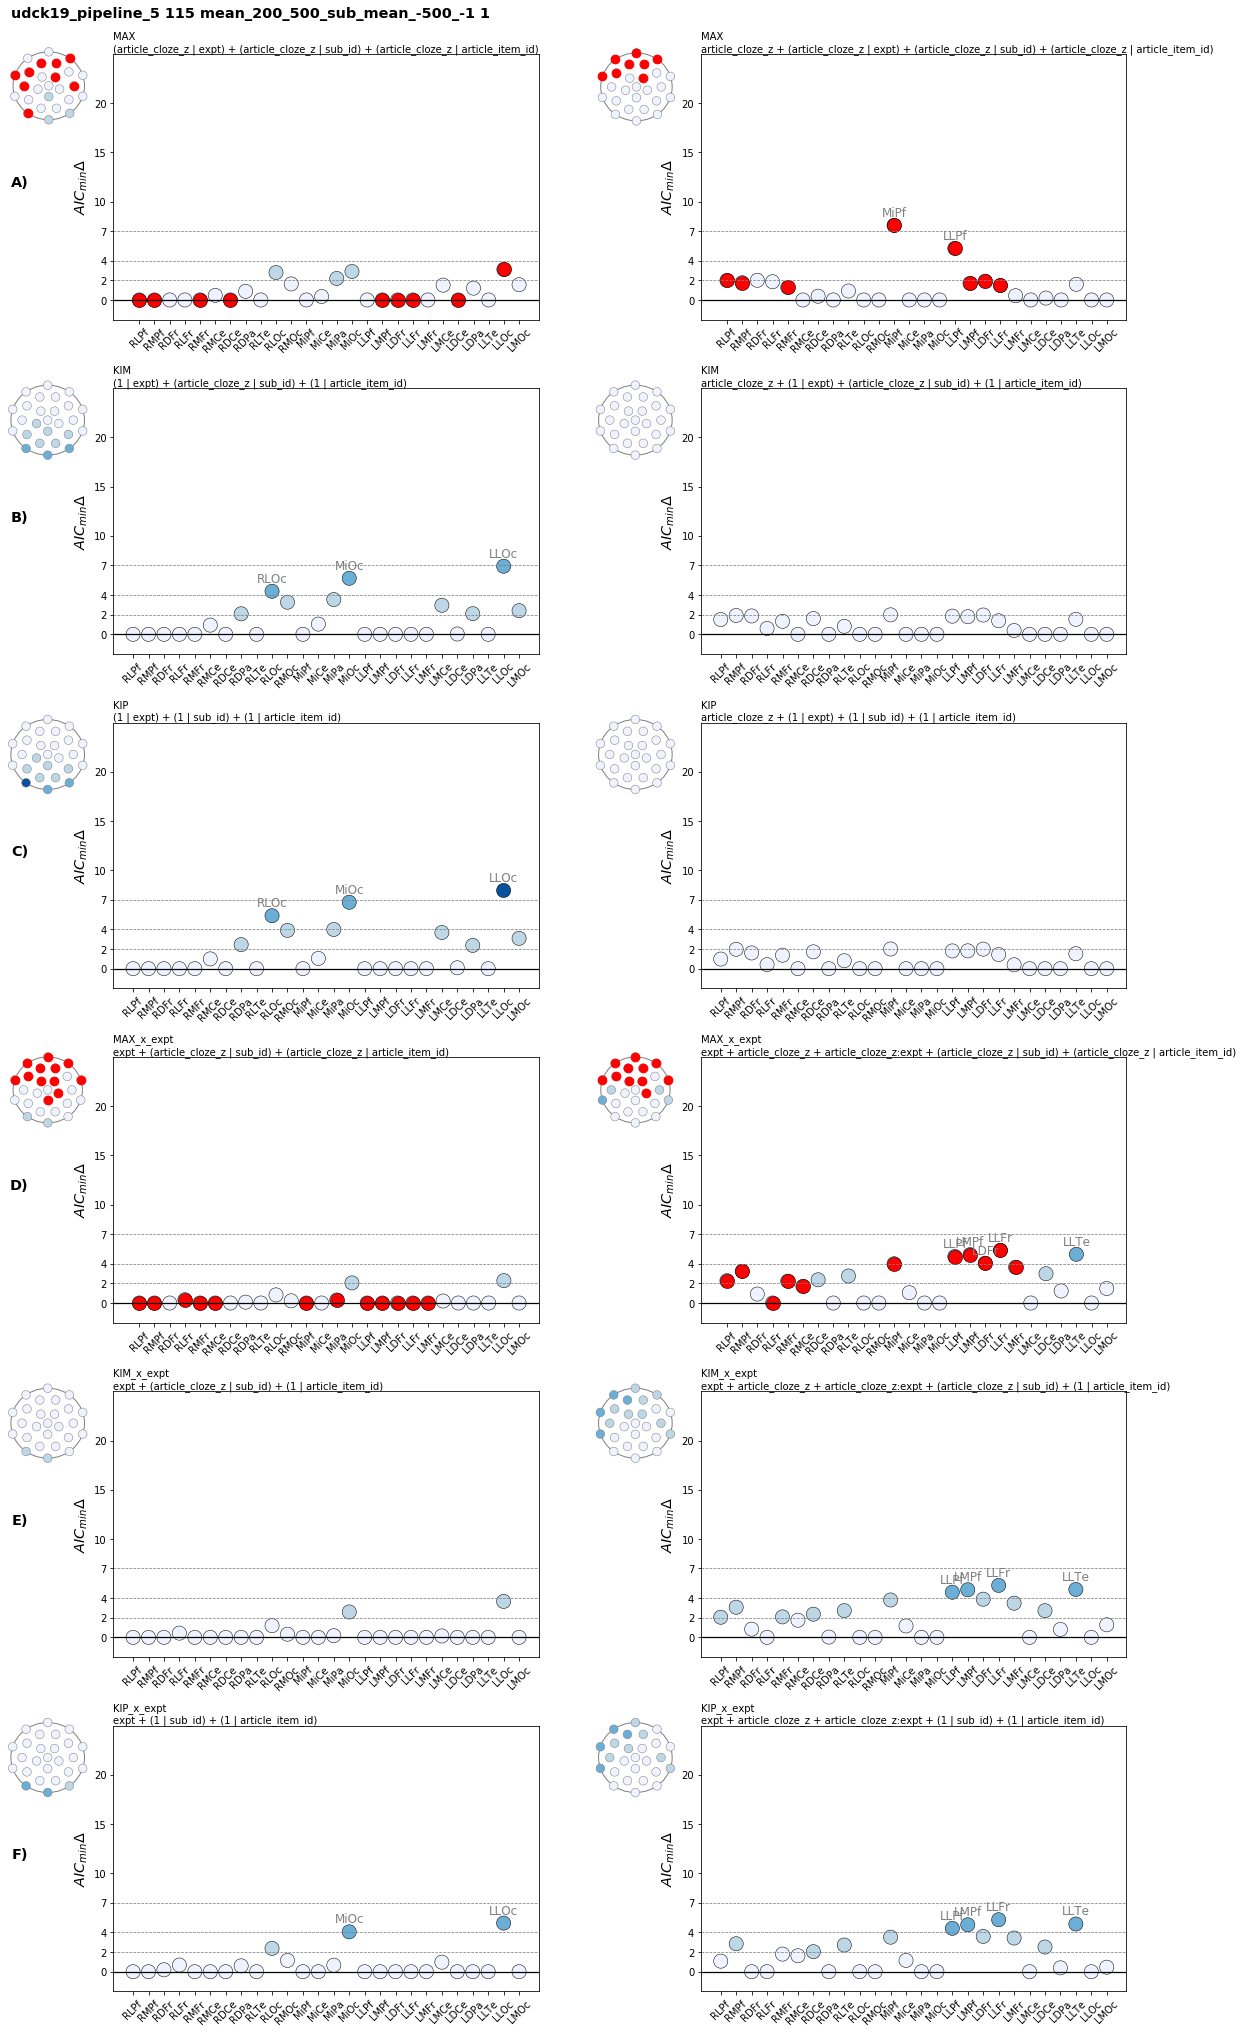

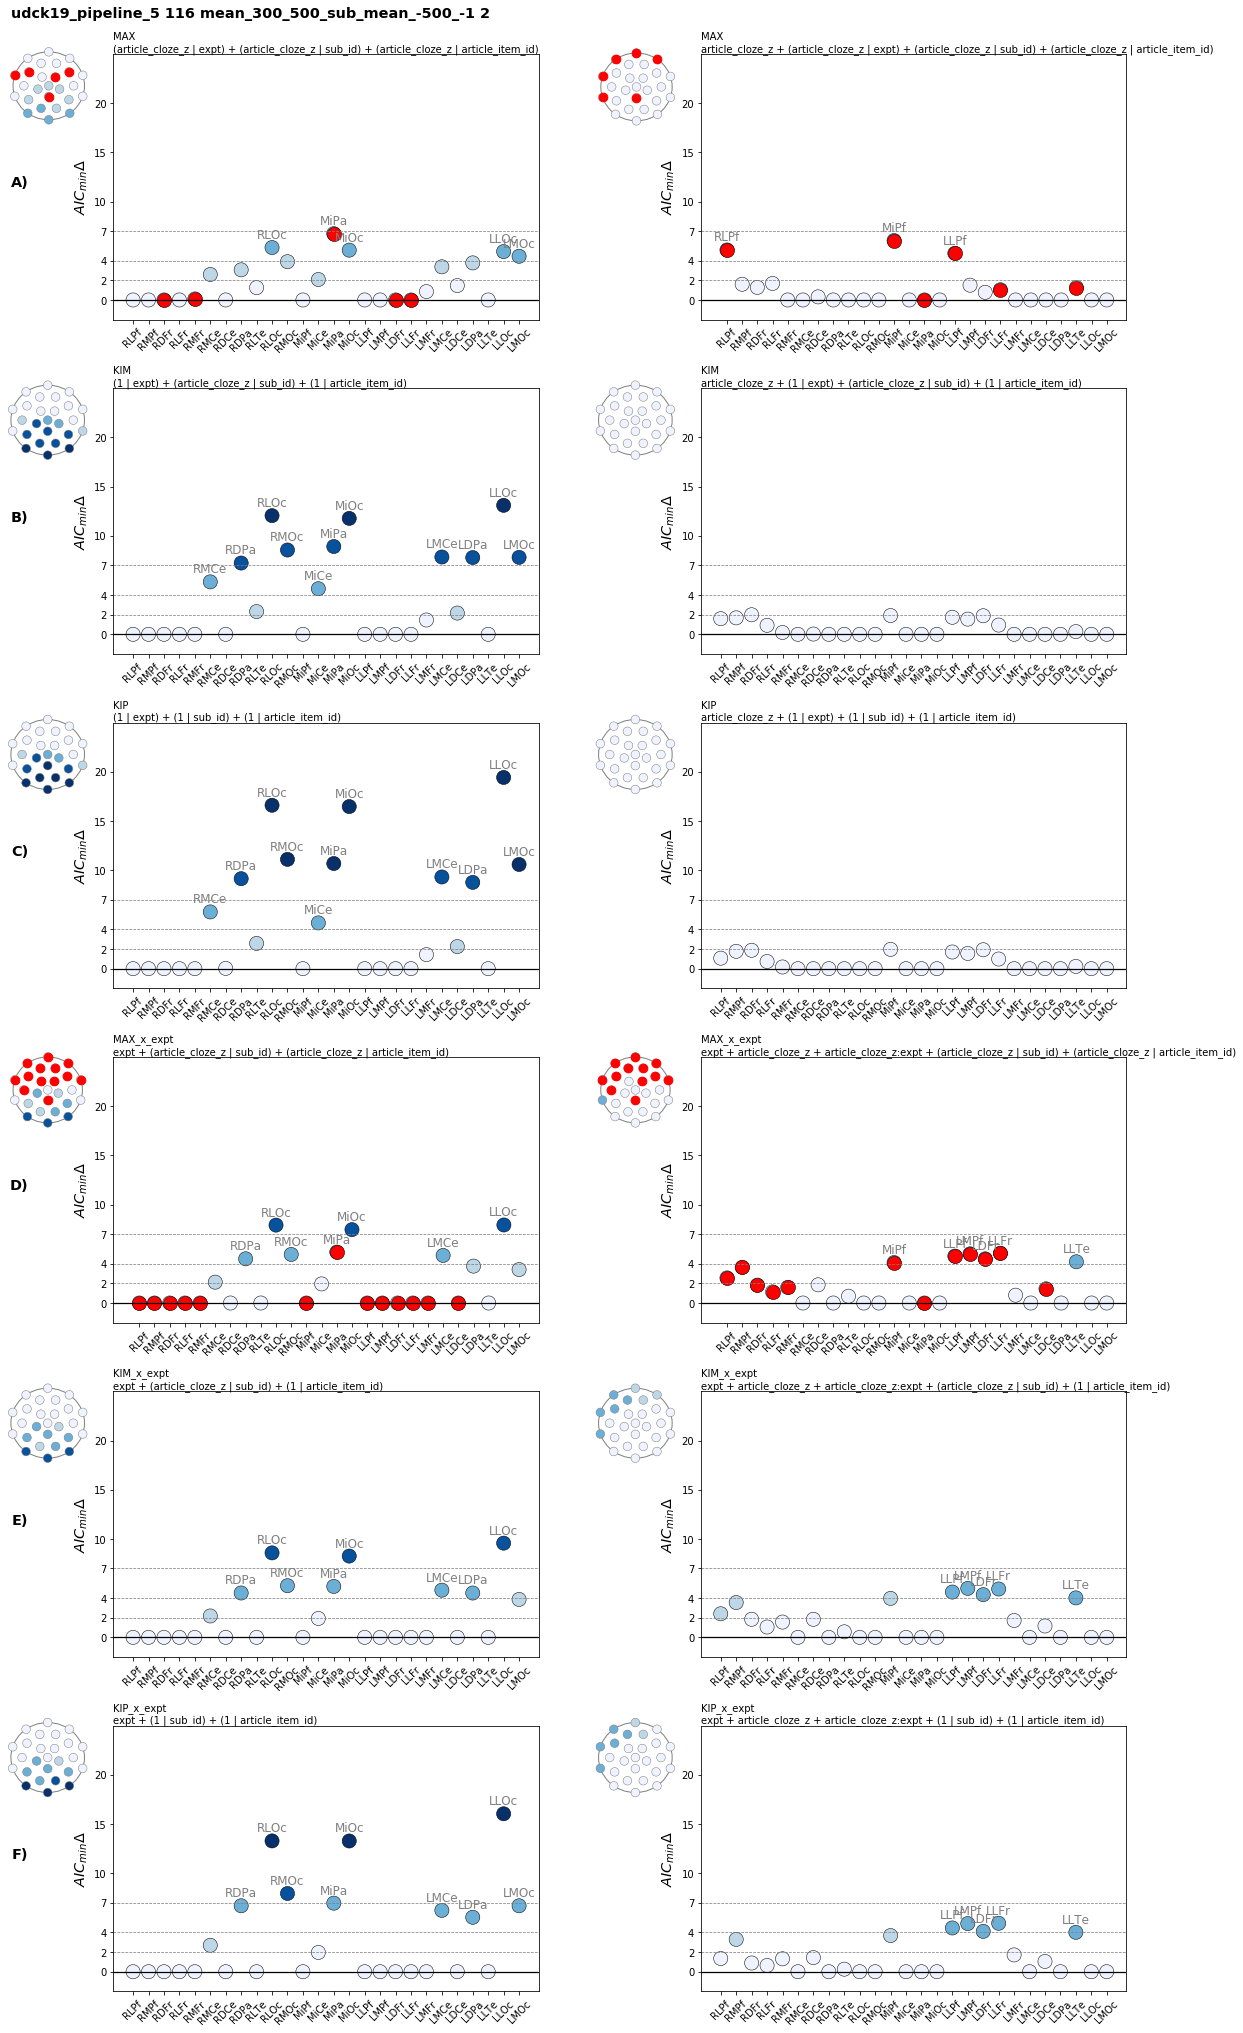

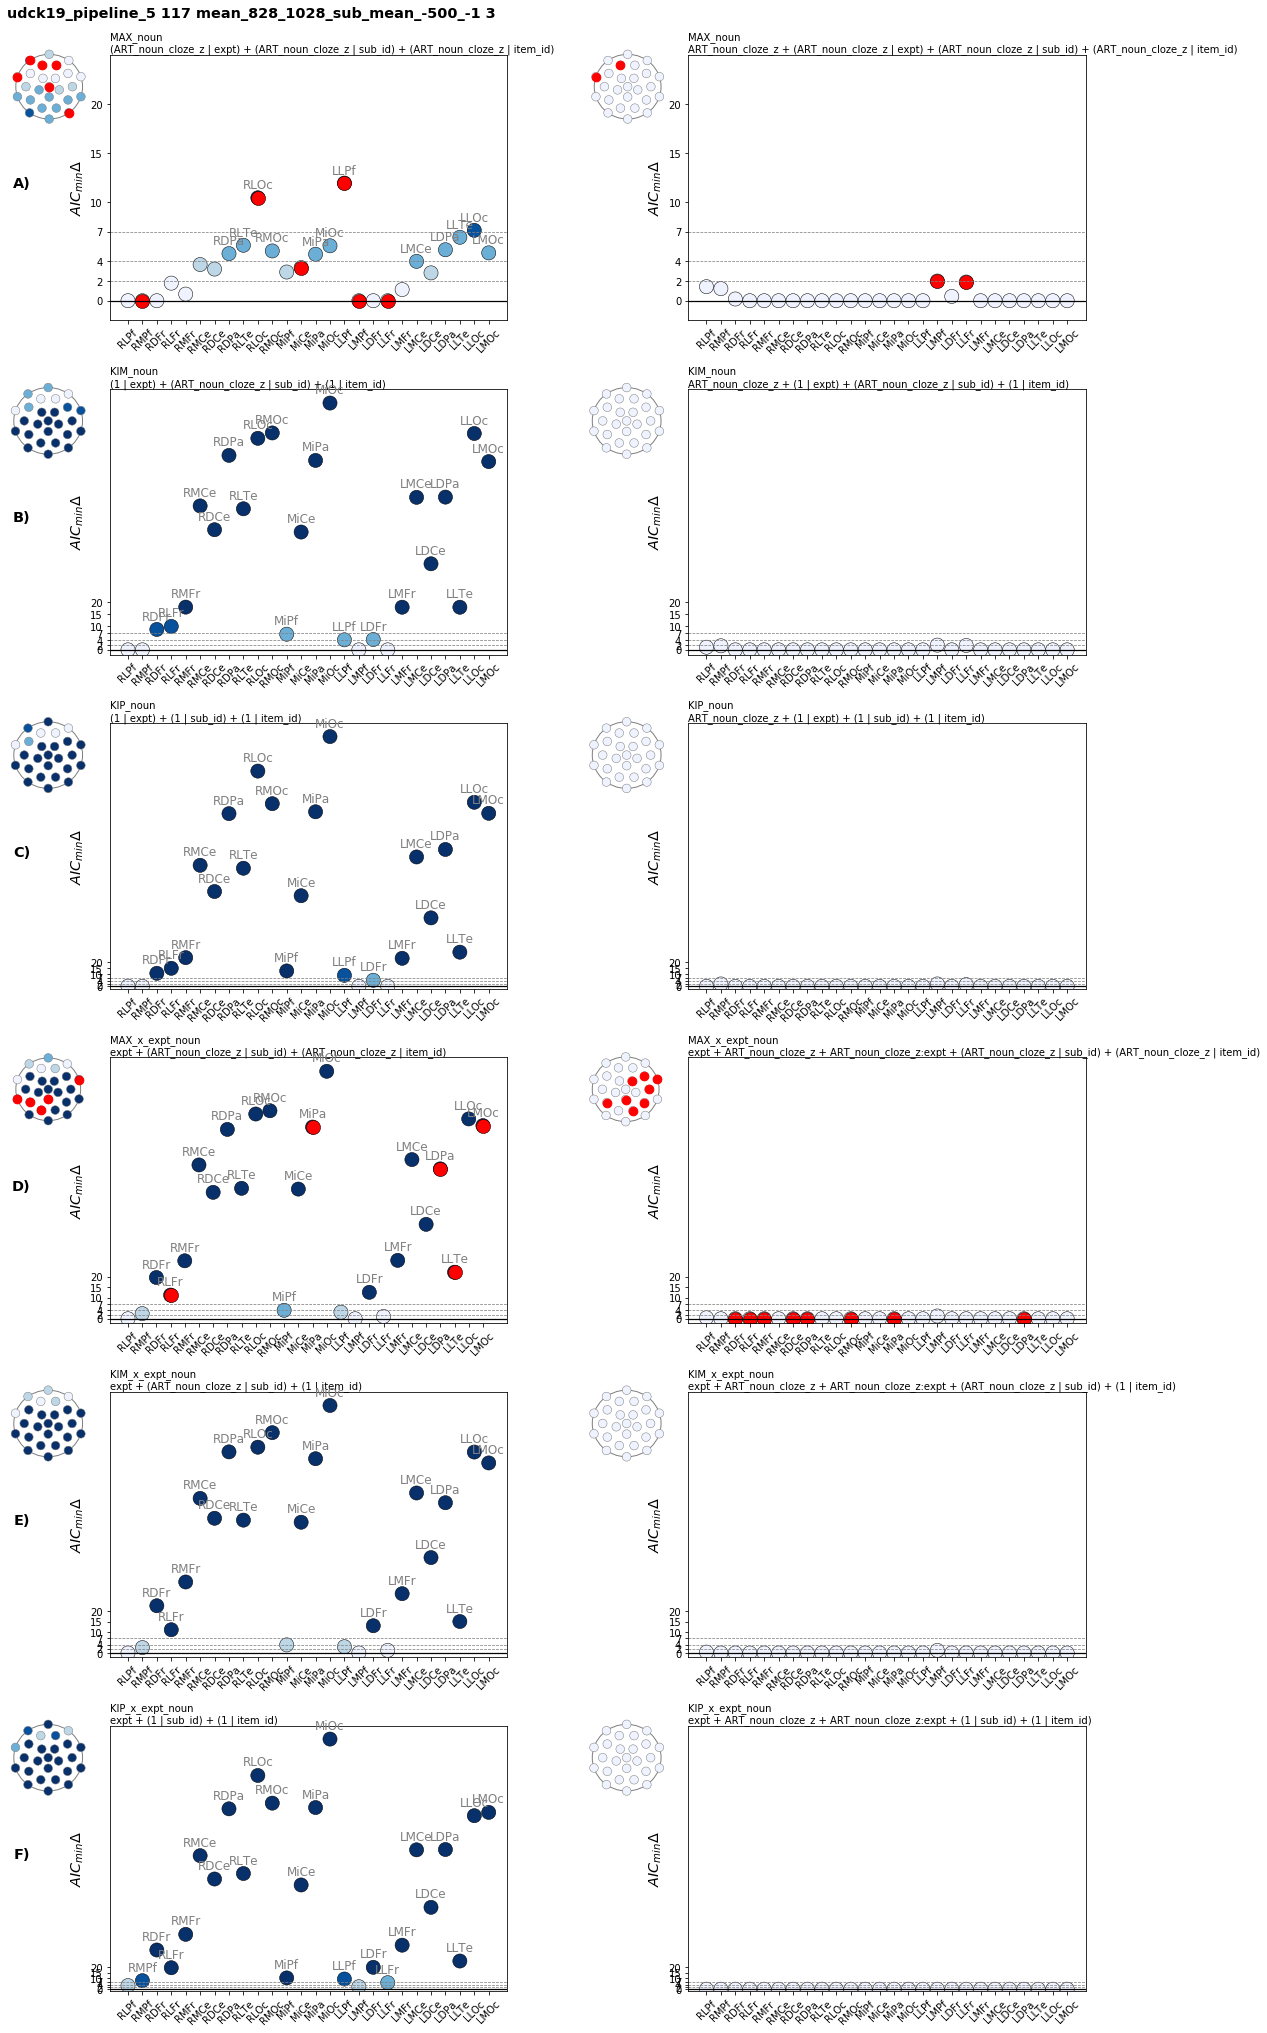

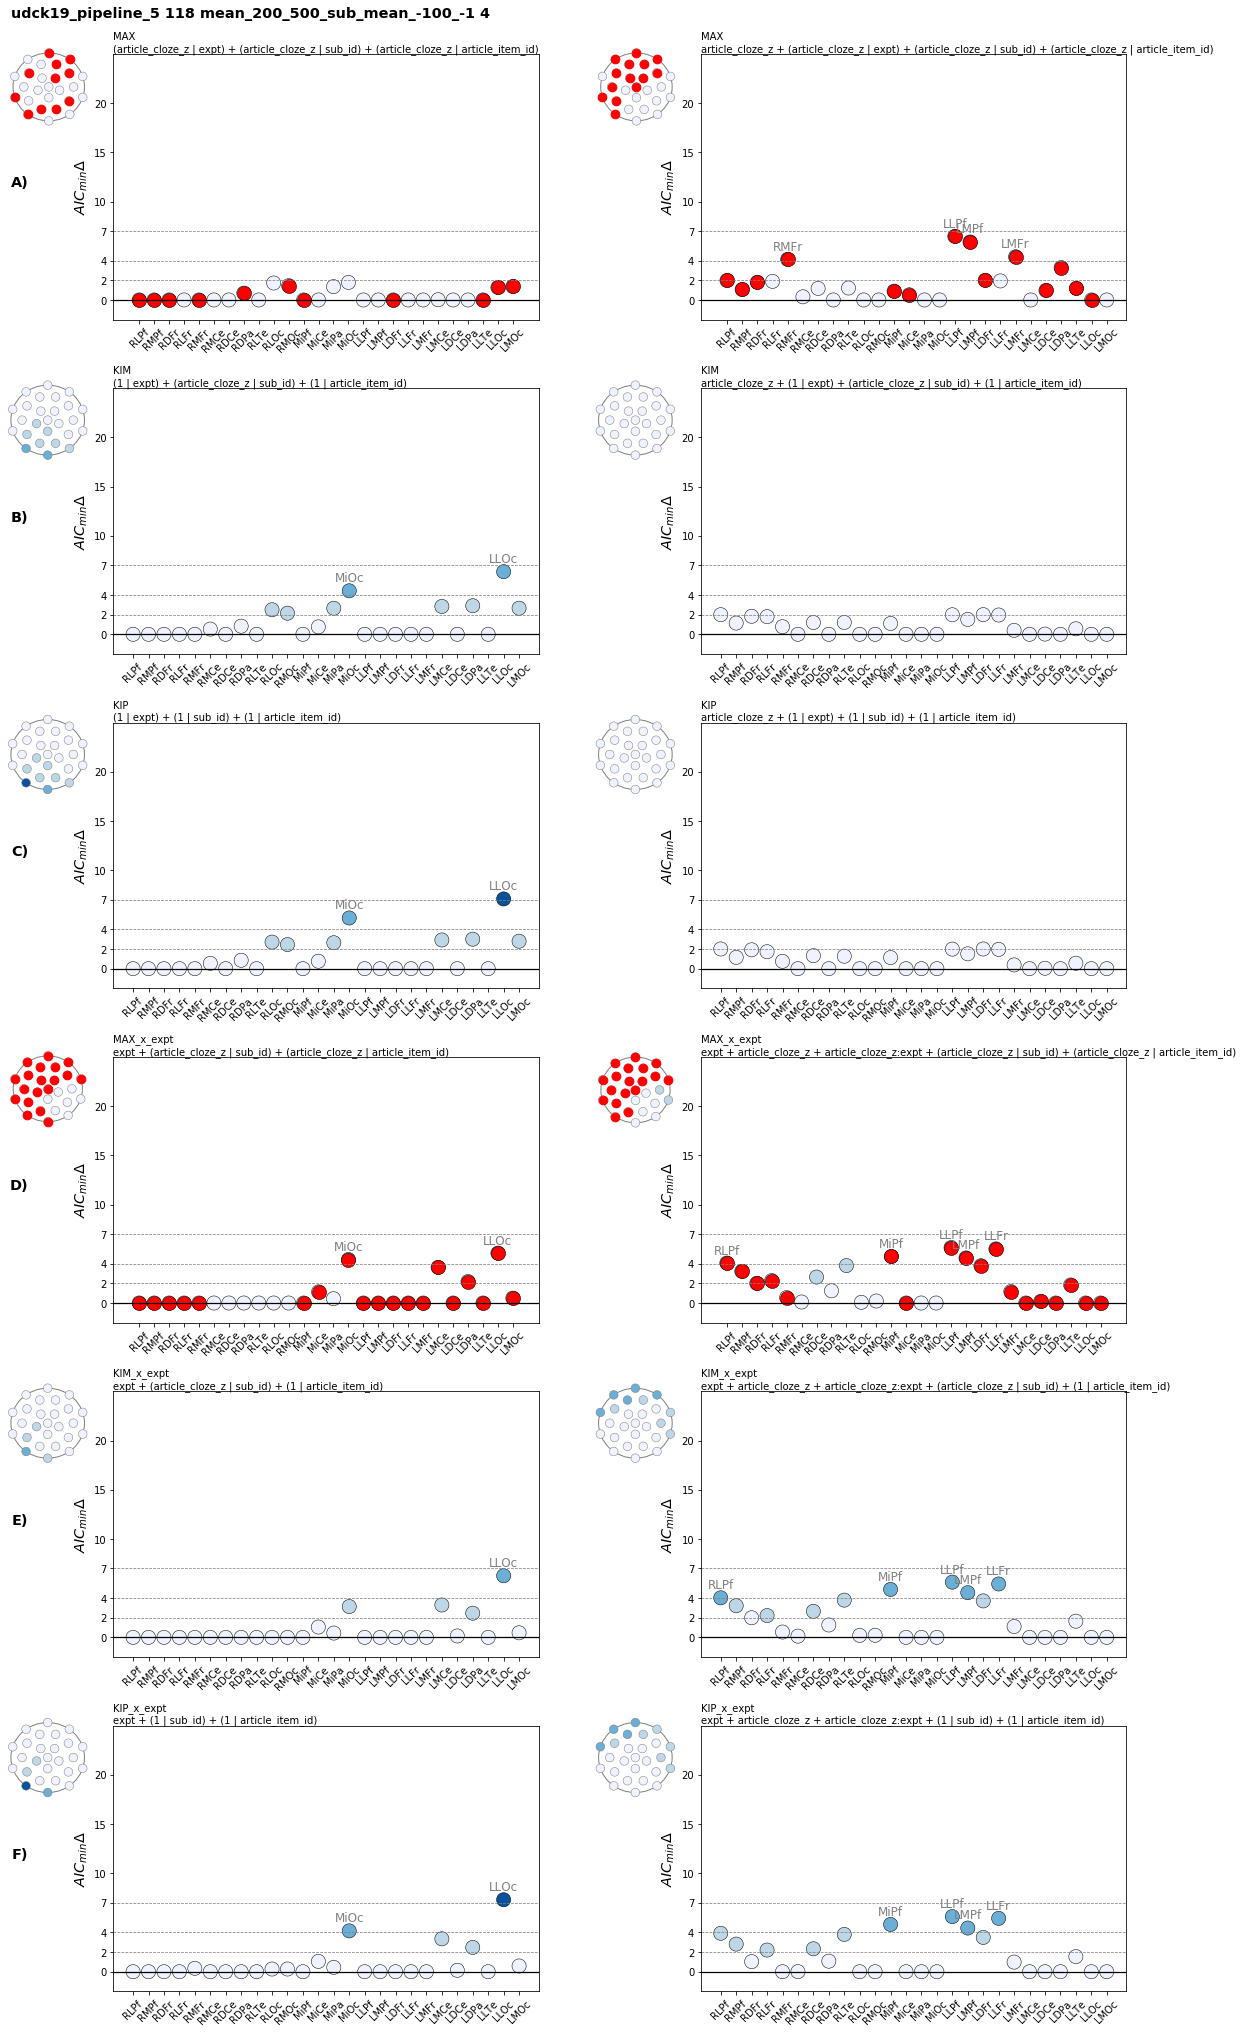

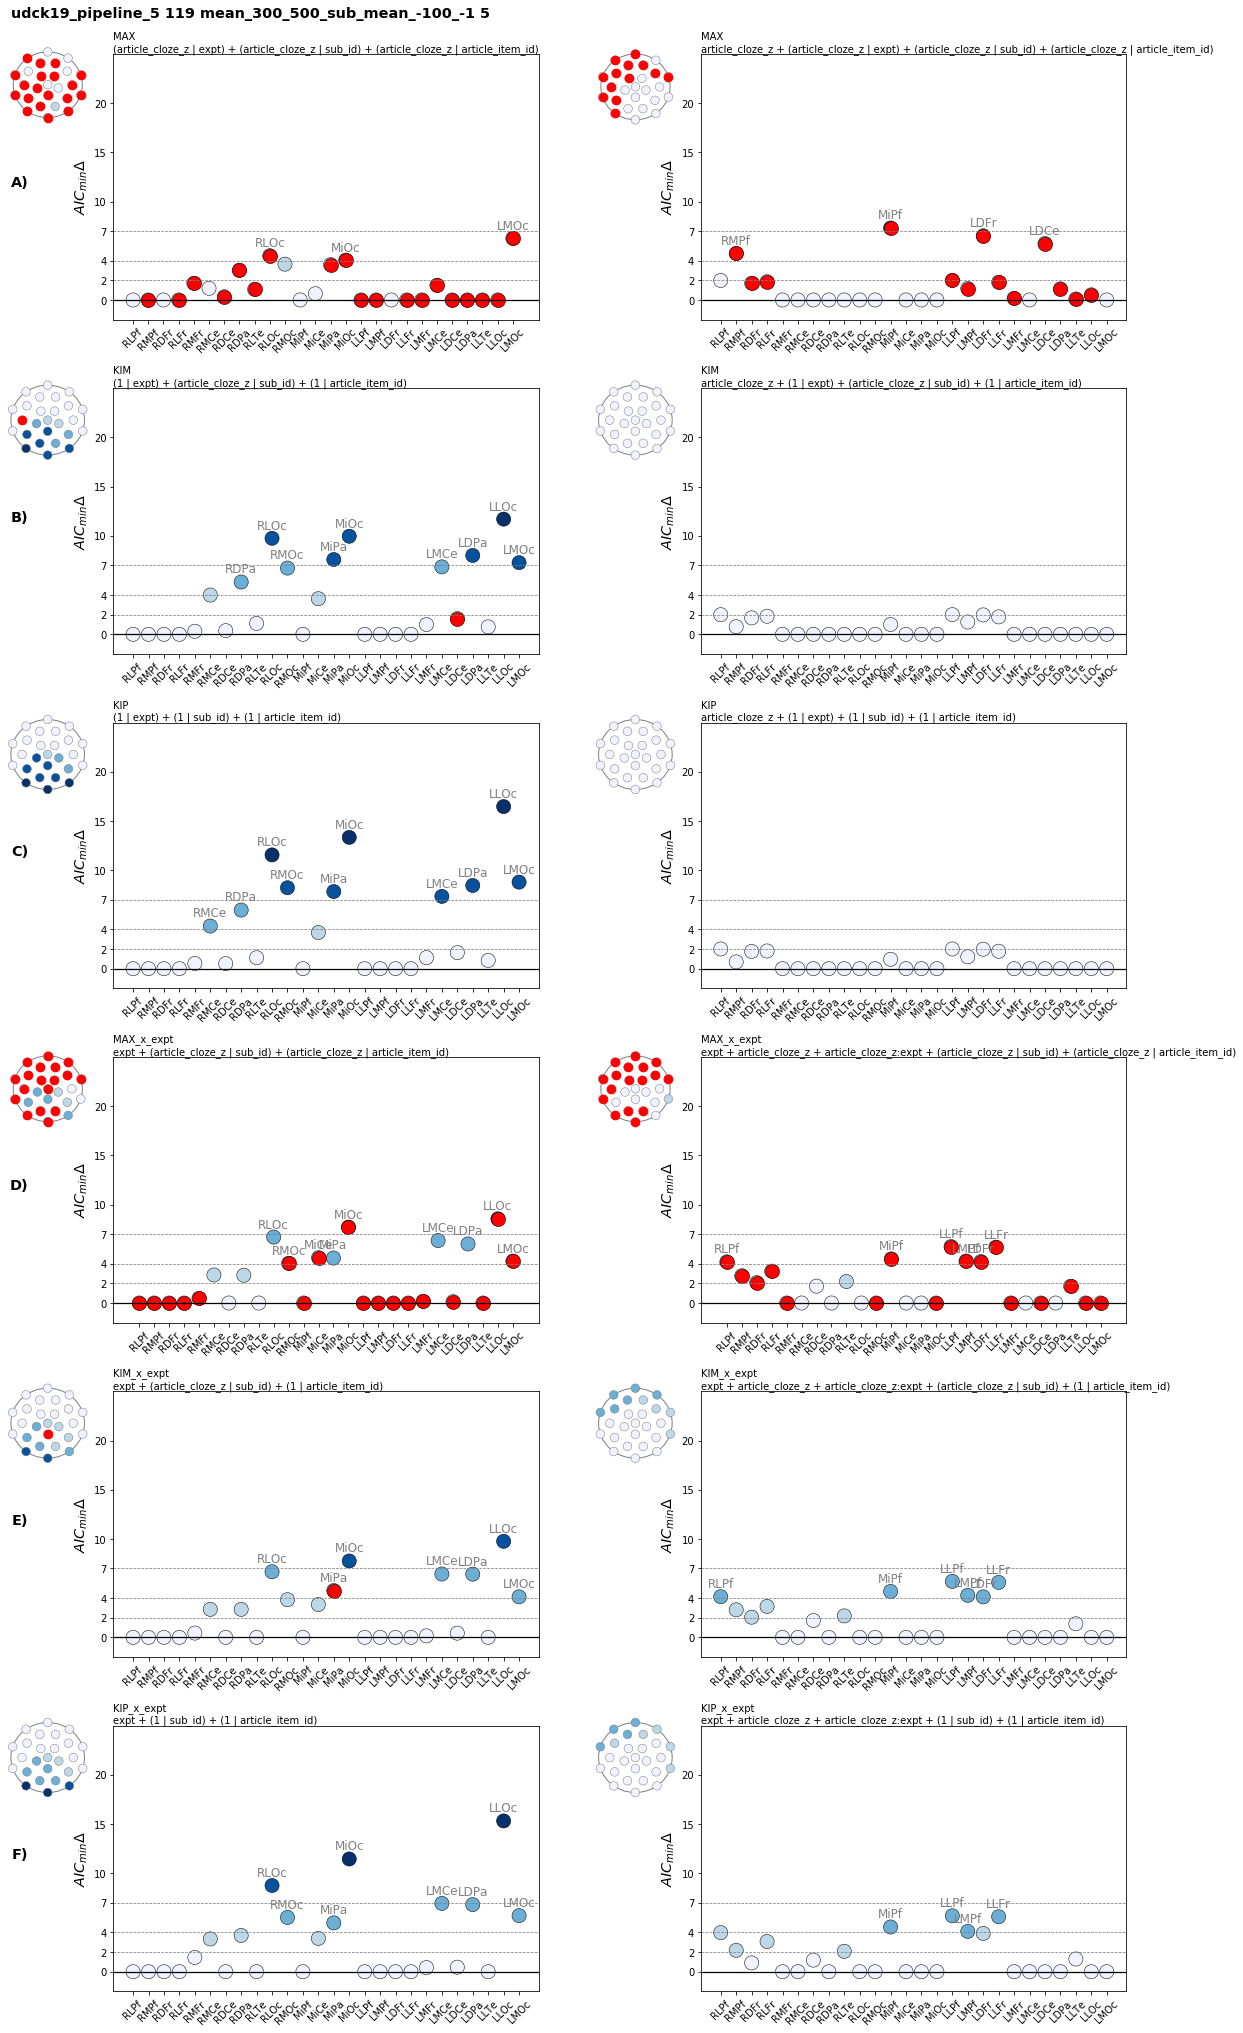

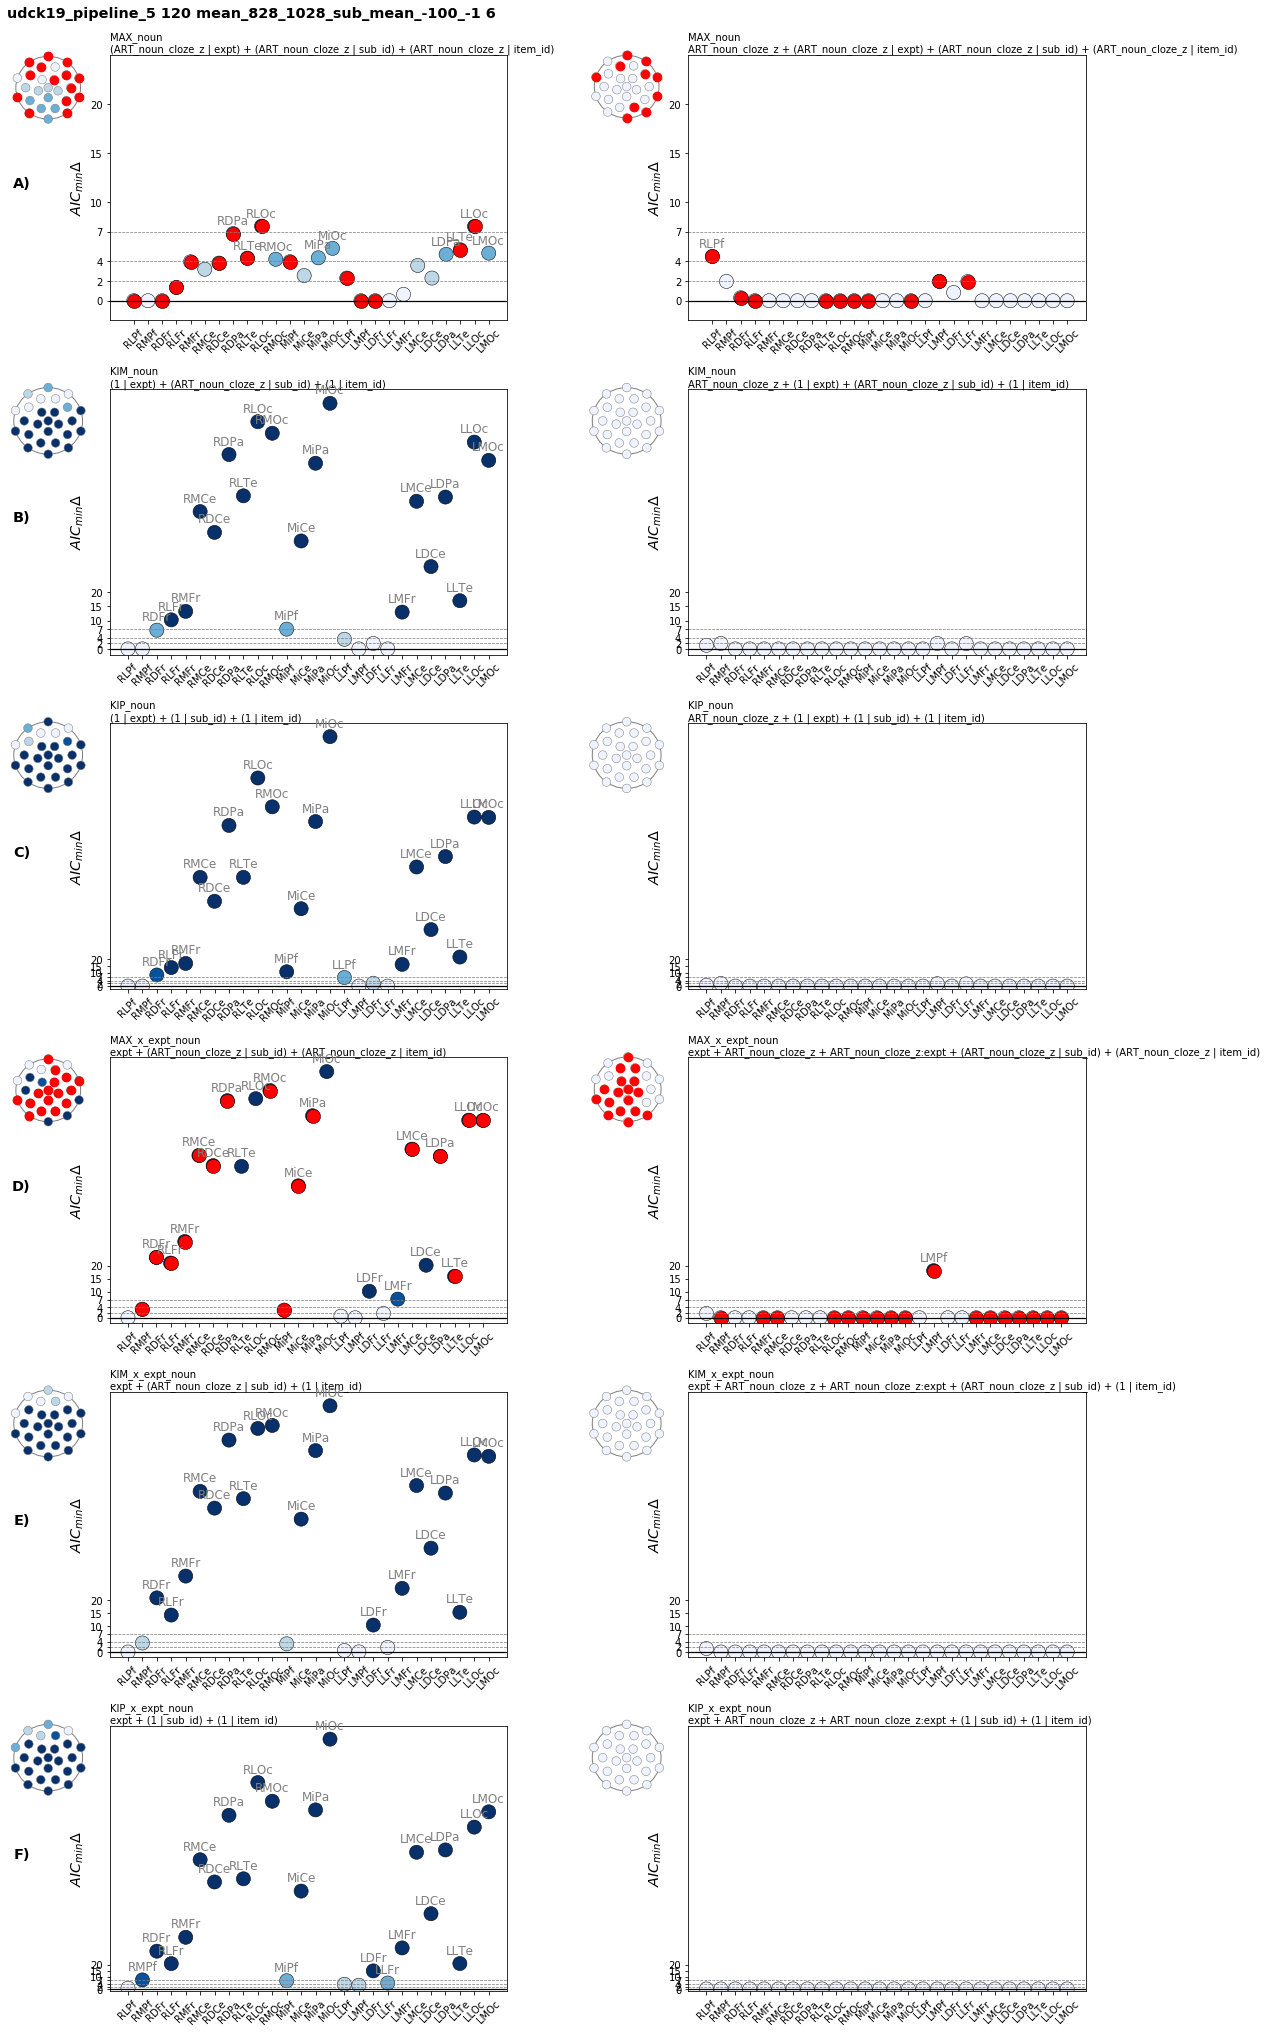

In [37]:
# ---------------
# render
# ---------------
plt.close('all')
for (interval, measure), aic_delta in n4_lmer_acz_comps_AIC_deltas_df.groupby(['Time', 'measure']):

    comps_keys = aic_delta.index.unique('proc')

    f, axs = plt.subplots(len(comps_keys), 2, figsize=(18, 28))
    fig_tag = f"{FIG_PREFIX} {FIG_COUNT} {measure} {interval}"
    f.suptitle(fig_tag, **FIG_TAG_SPECS)

    panel_idx = 0
    for row, proc in enumerate(comps_keys):
        # print(fig_tag, proc, 'row', row)

        # ------------------
        # AIC delta by channel
        # ------------------

        for aix, (model, plot_data) in enumerate(aic_delta.query('proc==@proc').groupby('model')):
            
            # layout the channel locations
            plot_data = plot_data.merge(
                CAP26_DF, how='inner', left_index=True, right_index=True
            ).reset_index('channel')
            
            ax = axs[row, aix]
            title_txt = ""
 
            yticks = [0, 2, 4, 7, 10, 15, 20]
            ax.set_yticks(yticks)
            ax.tick_params(axis='x', labelrotation=45)
            for hline in yticks[0:4]:
                if hline == 0:
                    ls, lw, lc = '-', 1.25, 'black'
                else:
                    ls, lw, lc = '--', 0.75, 'gray'
                ax.axhline(y=hline, ls=ls,  lw=lw, color=lc)
                
                
            ax.scatter(
                plot_data['channel'], 
                plot_data['min_delta'],
                c=plot_data['min_delta'],
                **marker_kws,
                cmap=cmap,
                norm=norm,
            )
            
    
            if aix == 0:
                ax.set(ylim=(-2, max(25, ax.get_ylim()[1])))
                ax.text(
                    x=-0.2,
                    y=0.5,
                    s=f"{panel_from_idx(panel_idx)})",
                    **panel_kws,
                    transform=ax.transAxes

                )
            else:
                # right column inherits y limits from left column
                ax.set(ylim =axs[row, 0].get_ylim())

            #ax.set_title(f"{proc}\n{model}", loc='left', horizontalalignment='left')
            ax.text(
                x=0, 
                y=1.0,
                s= f"{proc}\n{model}",
                horizontalalignment='left', 
                verticalalignment='bottom',
                transform=ax.transAxes
            )
            ax.set_ylabel(r"$AIC_{min} \Delta$", fontsize='x-large')
                
            # -----------    
            # inset head
            # -----------
            inset_size = .4   # as fraction of plot height
            ax_head = ax.inset_axes(
                # [0.02, 0.68, inset_size * ax.bbox.height / ax.bbox.width , inset_size], 
                [-0.25, 0.68, inset_size * ax.bbox.height / ax.bbox.width , inset_size], 
                transform=ax.transAxes,
                facecolor='none',
                frameon=False,  # supress x-y axis and ticks
                xticks = [],
                yticks = [],
                
            )
 
            ax_head.set_aspect('equal')
            
            # native x, y or lambert
            x_col, y_col = 'x_lambert', 'y_lambert'
            scatter = ax_head.scatter(
                plot_data[x_col],
                plot_data[y_col],
                c=plot_data['min_delta'],
                cmap=cmap,
                norm=norm,
                **head_marker_kws,
            )
            
            vertex = CAP26_DF.query('channel == "MiCe"')
            circ = mpl.patches.Circle(
                (vertex[x_col], vertex[y_col]), 
                radius=1, 
                transform=ax_head.transData, 
                edgecolor='gray', 
                facecolor='none',
                clip_on=False,
            )
            ax.add_patch(circ)

            # ---------------------------------------
            # decorate both with text labels and warnings
            # --------------------------------------
            chan_text = plot_data[plot_data['min_delta'] > 4.0]
            chan_text.apply(
                lambda r: ax.text(
                    x=r['channel'], 
                    y=r['min_delta'] + (.025 * ax.get_ylim()[1]), # nudge text up 
                    s=r['channel'],
                    **chan_label_kws
                ),
                1
            )
            
            # paint the warnings
            wrns = plot_data[plot_data['has_warning'] == 1.0]
            wrns.apply(
                lambda r:
                ax.scatter(x=r['channel'], y=r['min_delta'], c='red', **marker_kws),
                1
            )                
            wrns.apply(
                lambda r: 
                ax_head.scatter(x=r[x_col], y=r[y_col], c='red', s=head_marker_kws['s']),
                1
            )
        
        panel_idx += 1
        
    f.subplots_adjust(wspace=.75)
    f.tight_layout()
    FIG_COUNT = udck19_figsave(f, fig_tag, FIG_COUNT)
    

In [17]:
n4_lmer_acz_comps_summaries_long_df = n4_lmer_acz_comps_summaries_df.stack().to_frame()
n4_lmer_acz_comps_summaries_long_df.index.names = (
    n4_lmer_acz_comps_summaries_long_df.index.names[0:-1] + ['channel']
)

data_cols=['Estimate', 'has_warning']
data_df = n4_lmer_acz_comps_summaries_long_df.query("key in @data_cols").unstack('key')
data_df.columns = data_cols
data_df.head()

Estimate  \
Time model                                             beta        proc measure                       probe   channel             
1    (1 | expt) + (1 | sub_id) + (1 | article_item_id) (Intercept) KIP  mean_200_500_sub_mean_-500_-1 article RLPf     0.177340   
                                                                                                              RMPf    -0.596036   
                                                                                                              RDFr    -0.713664   
                                                                                                              RLFr    -0.257049   
                                                                                                              RMFr    -0.886904   

                                                                                                                       has_warning  
Time model                                             beta        proc measure                       probe   channel               
1    (1 | expt) + (1 | sub_id) + (1 | article_item_id) (Intercept) KIP  mean_200_500_sub_mean_-500_-1 article RLPf             0.0  
                                                                                                              RMPf             0.0  
                                                                                                              RDFr             0.0  
                                                                                                              RLFr             0.0  
                                                                                                              RMFr             0.0

# Scalp distribution of model parameter estimates: $\hat{\beta_{j}}$

* Note different scales for intercept and cloze

* X indicates LMER warning

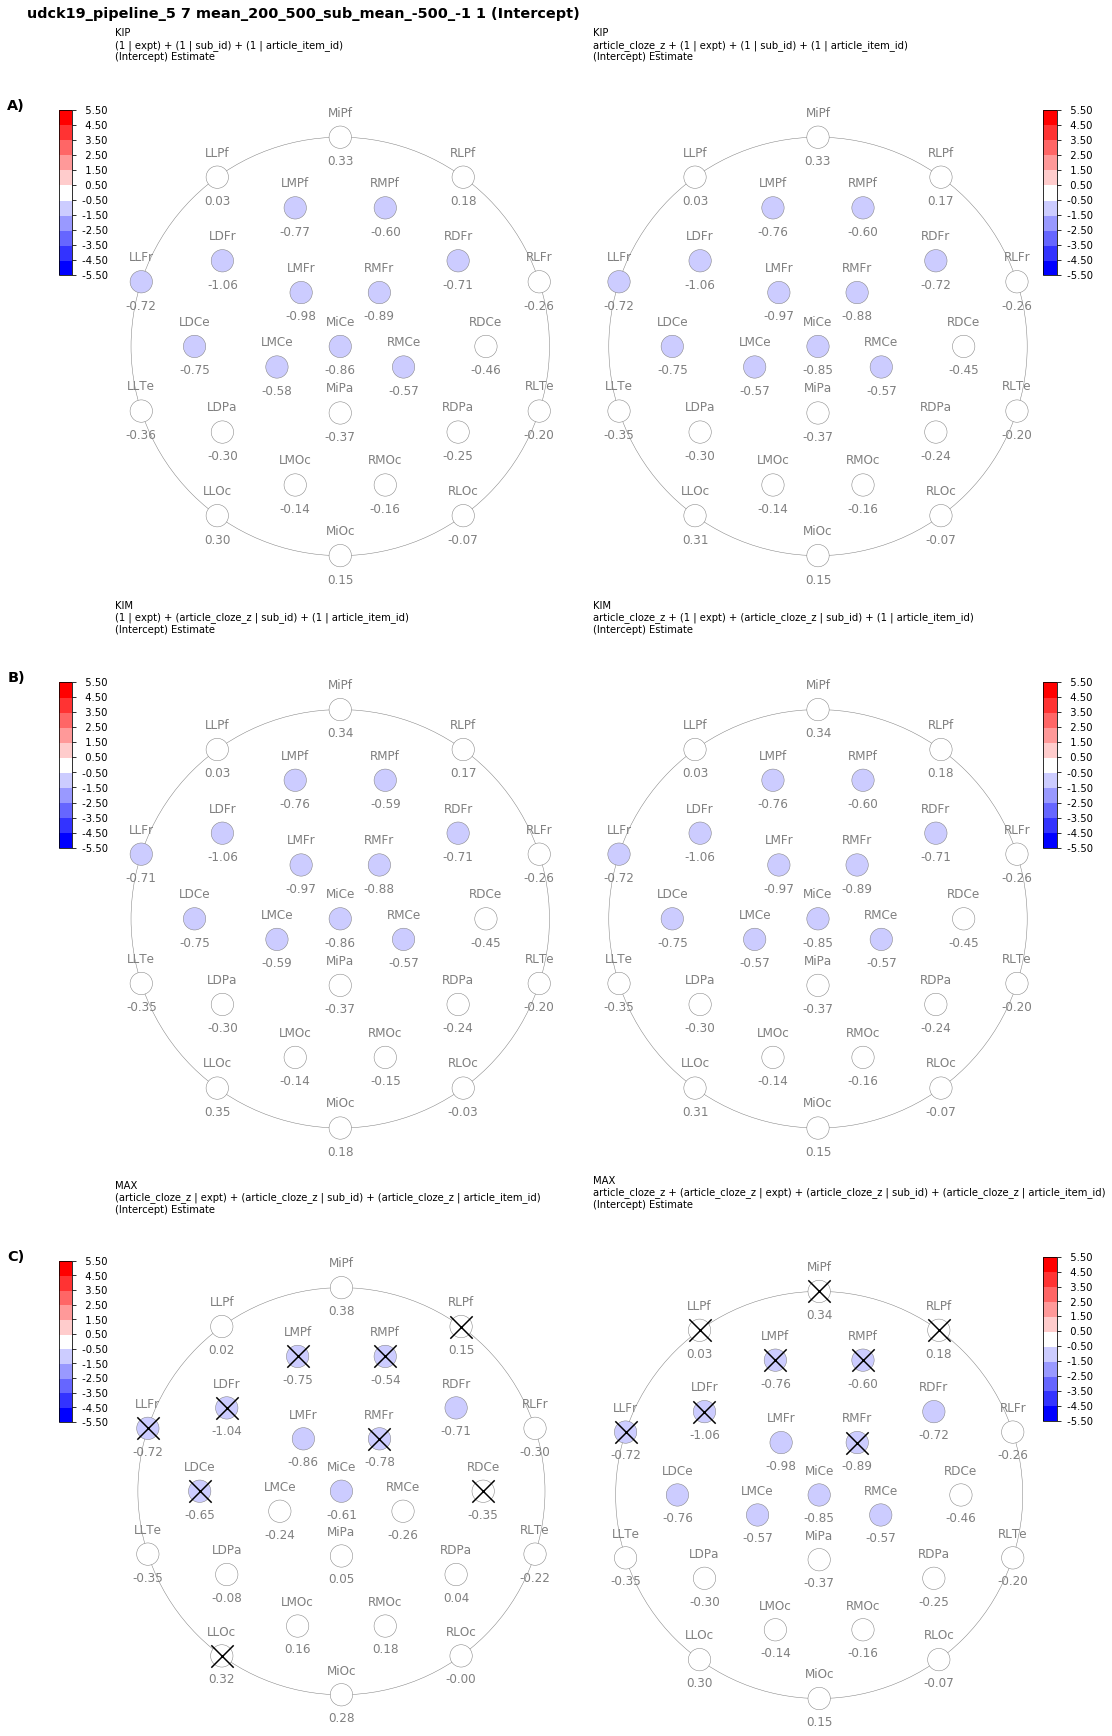

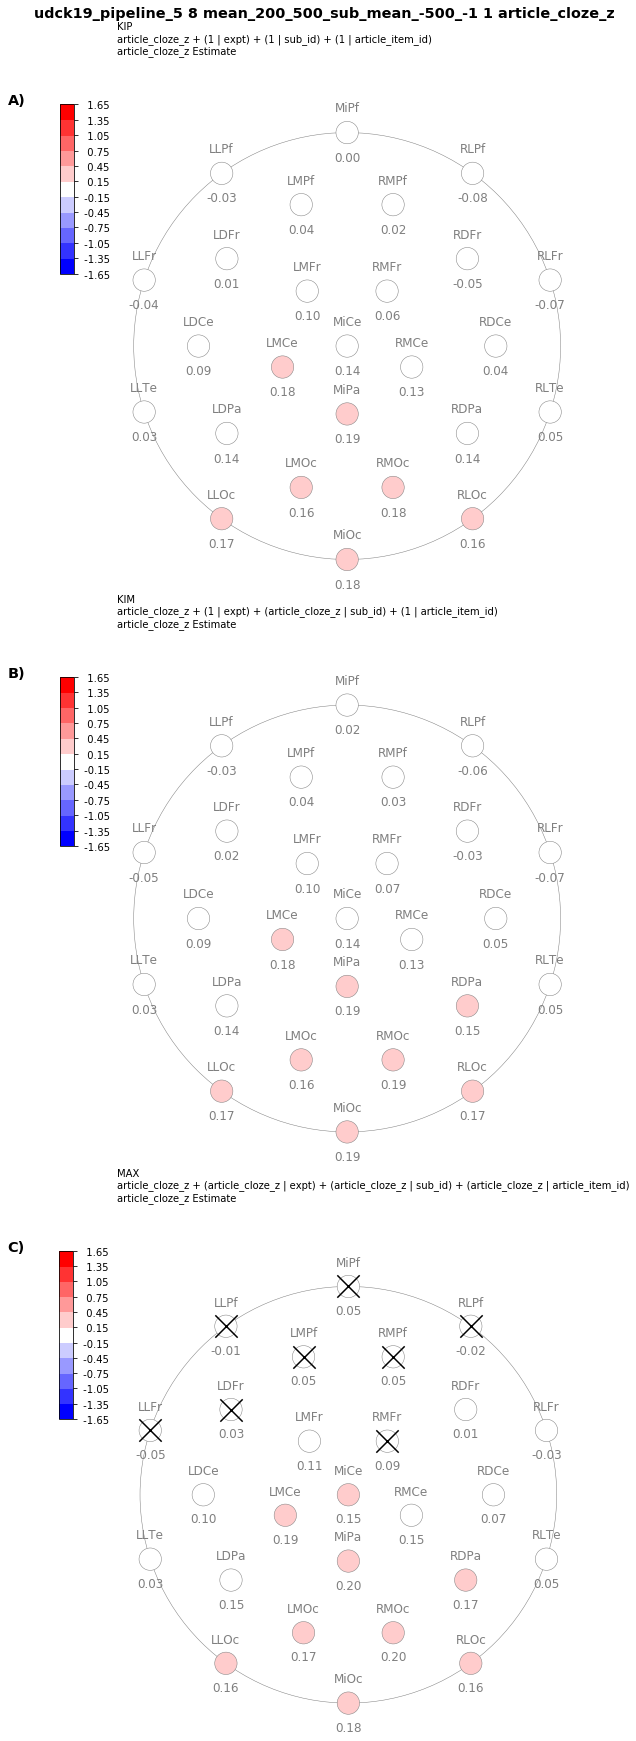

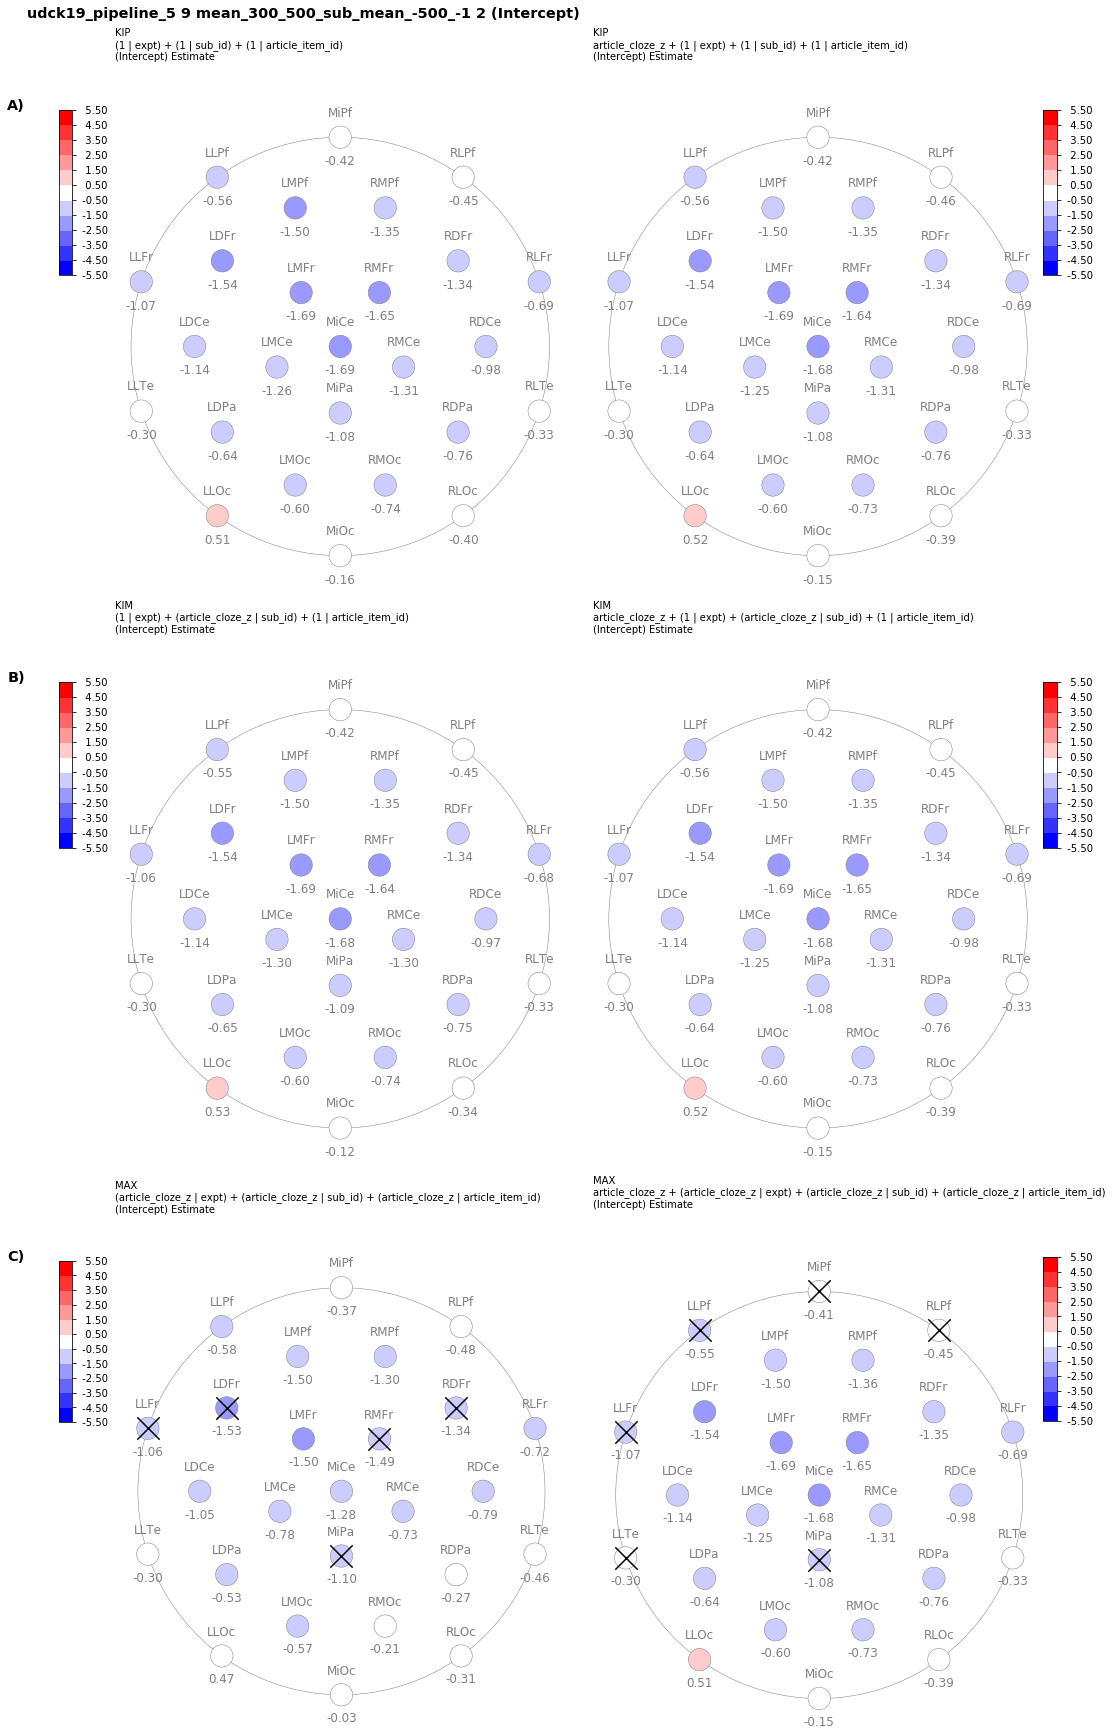

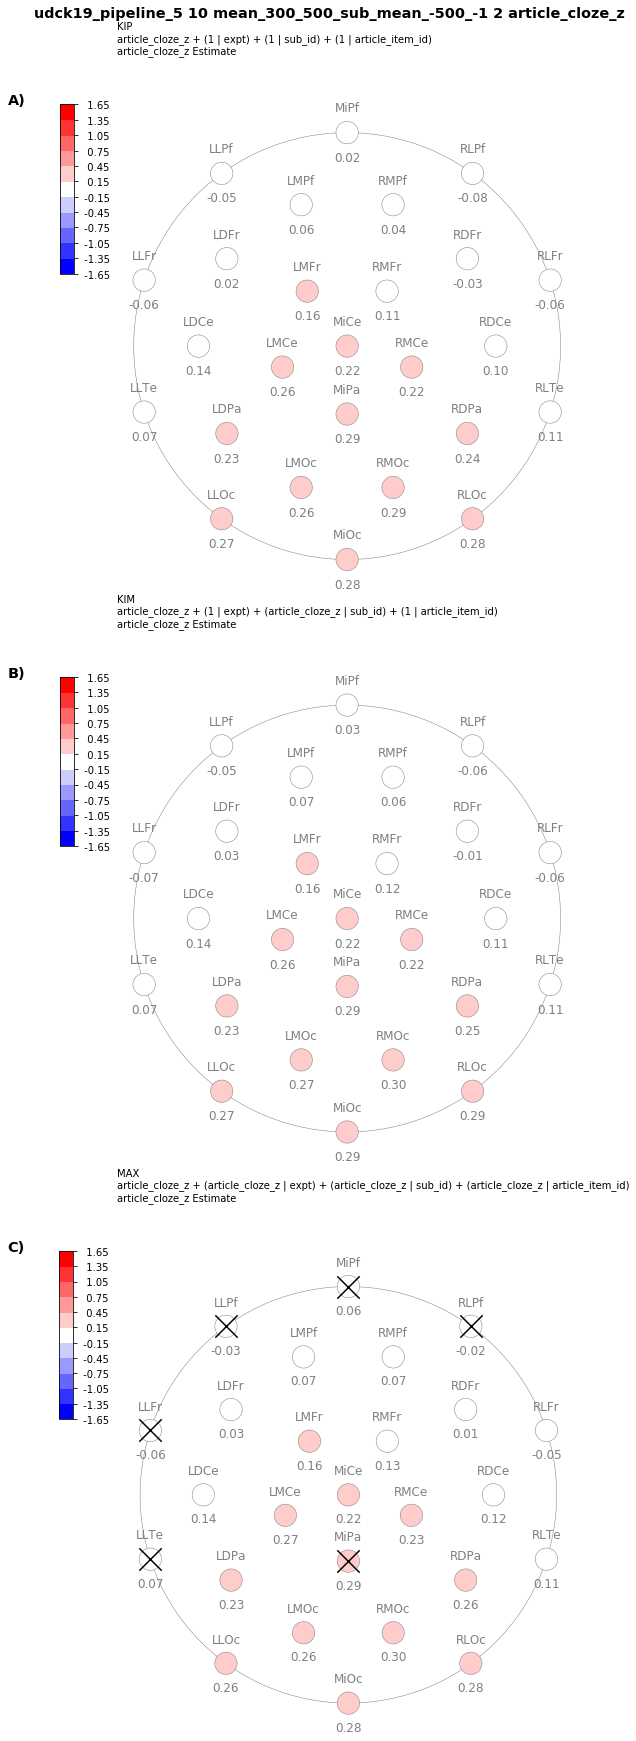

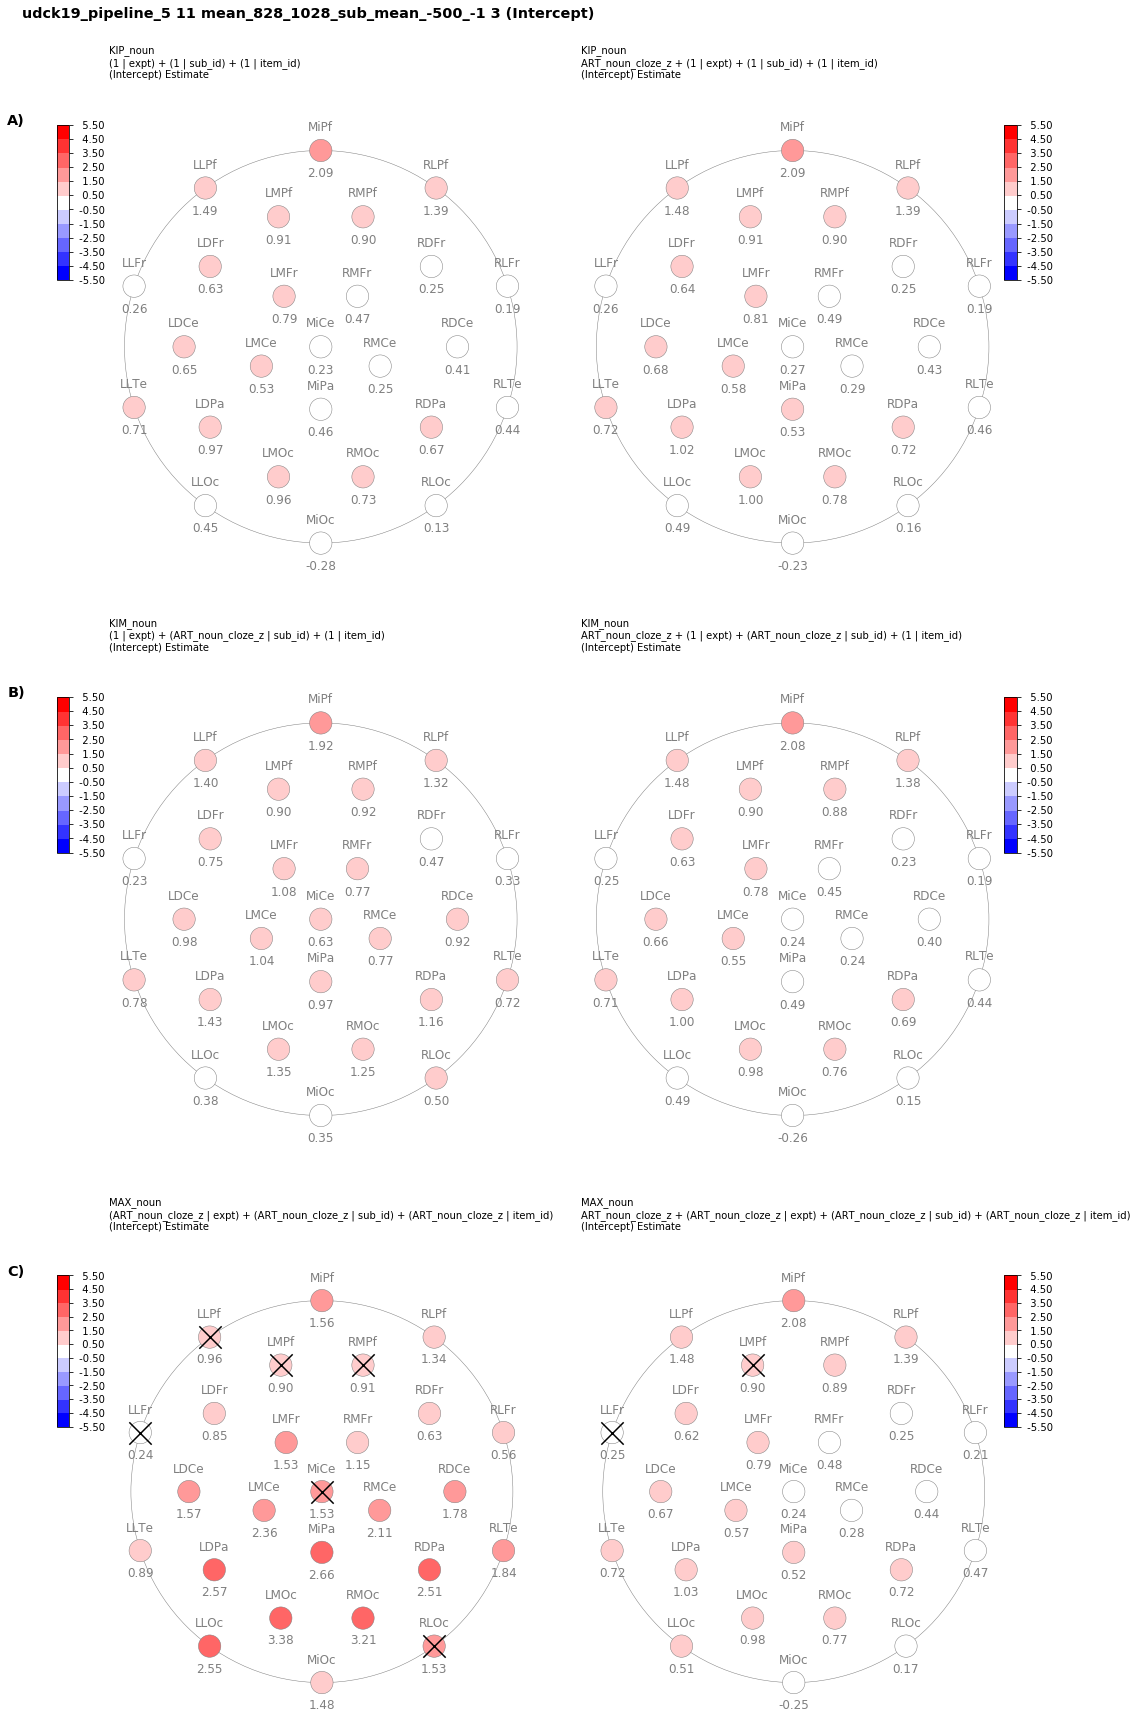

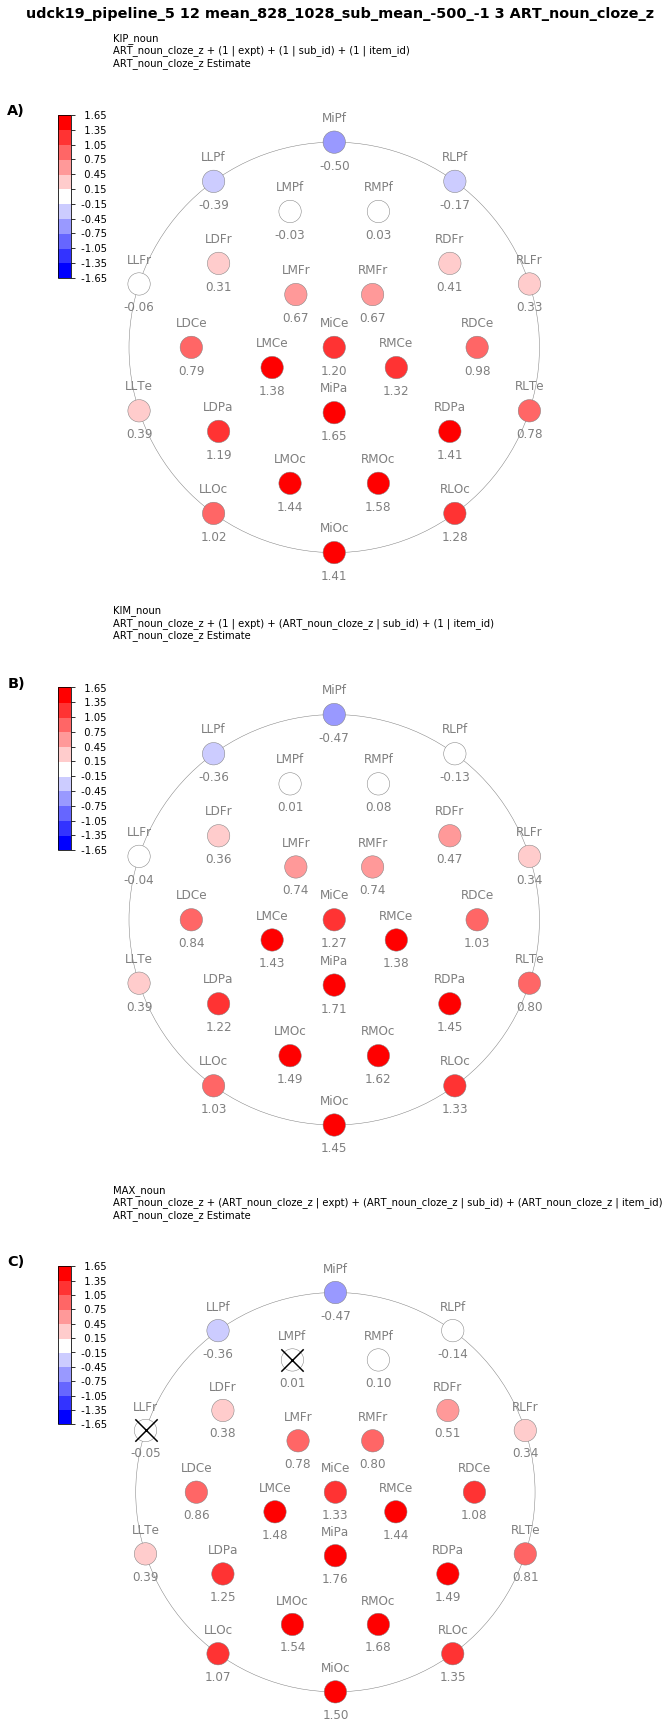

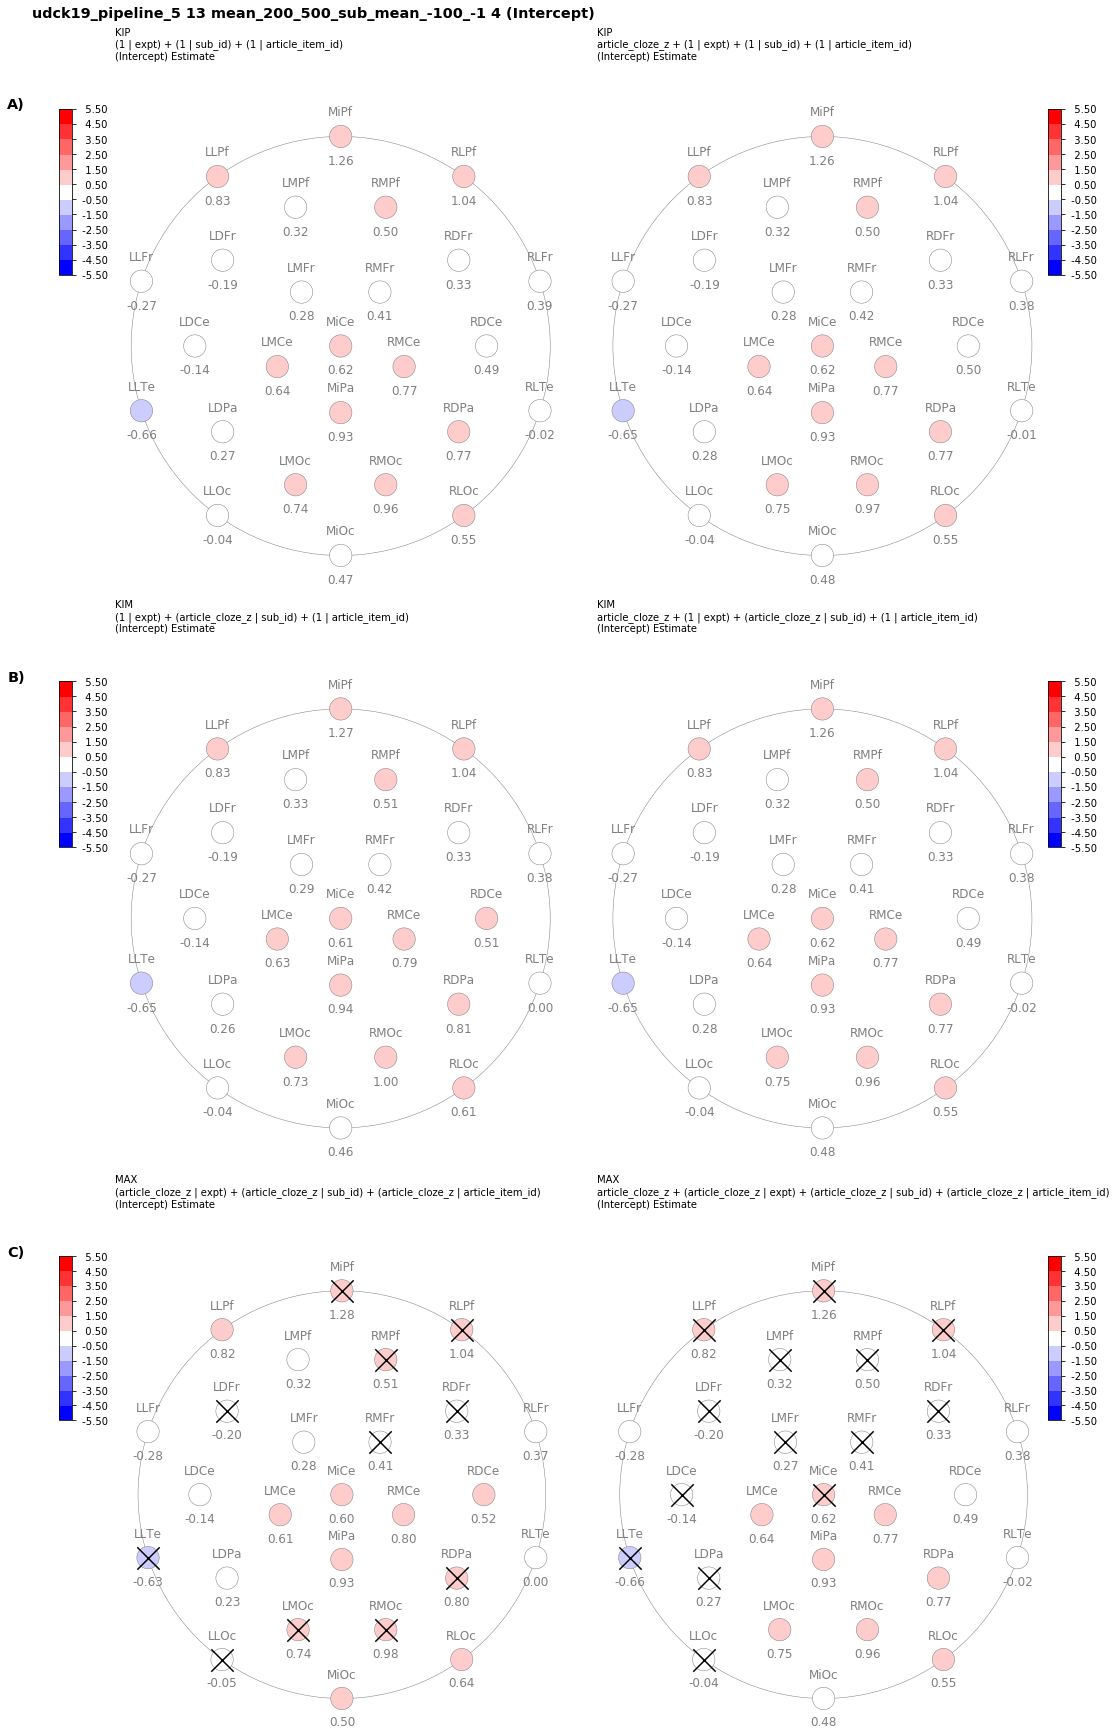

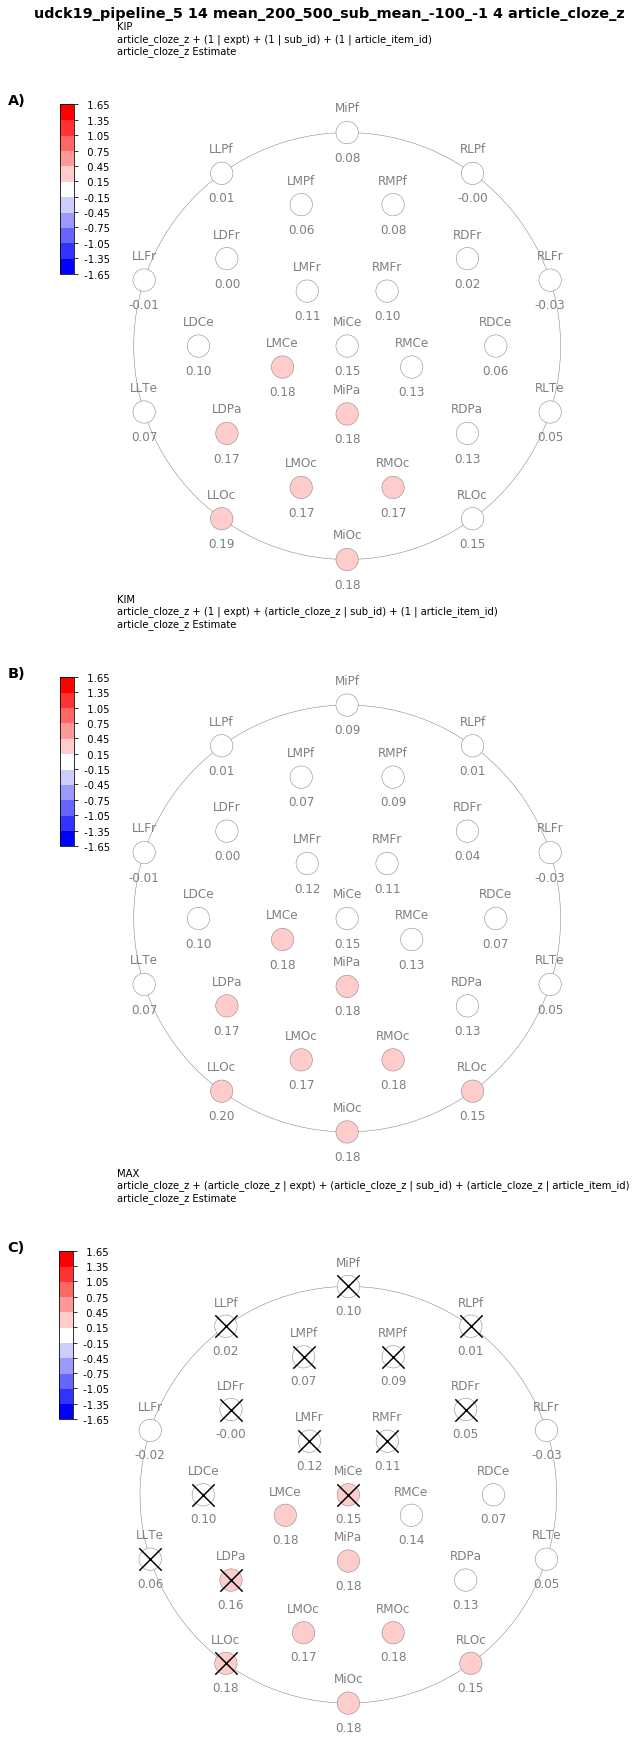

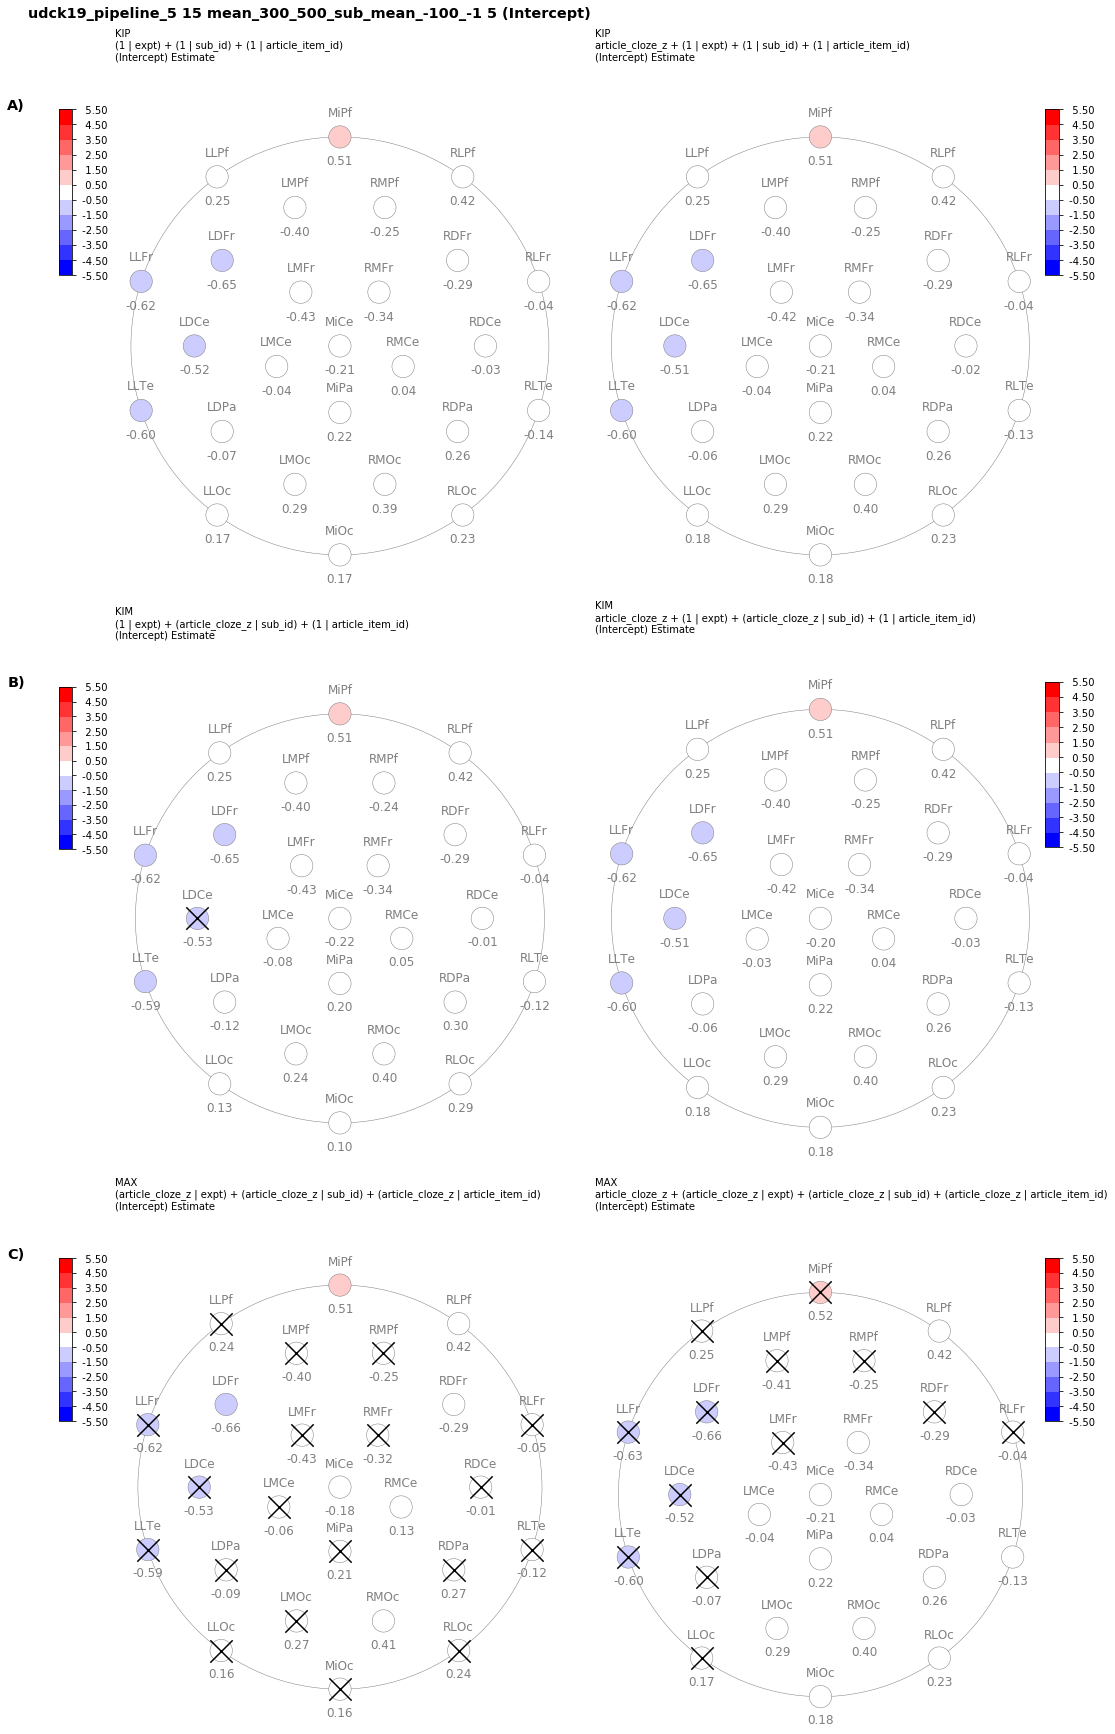

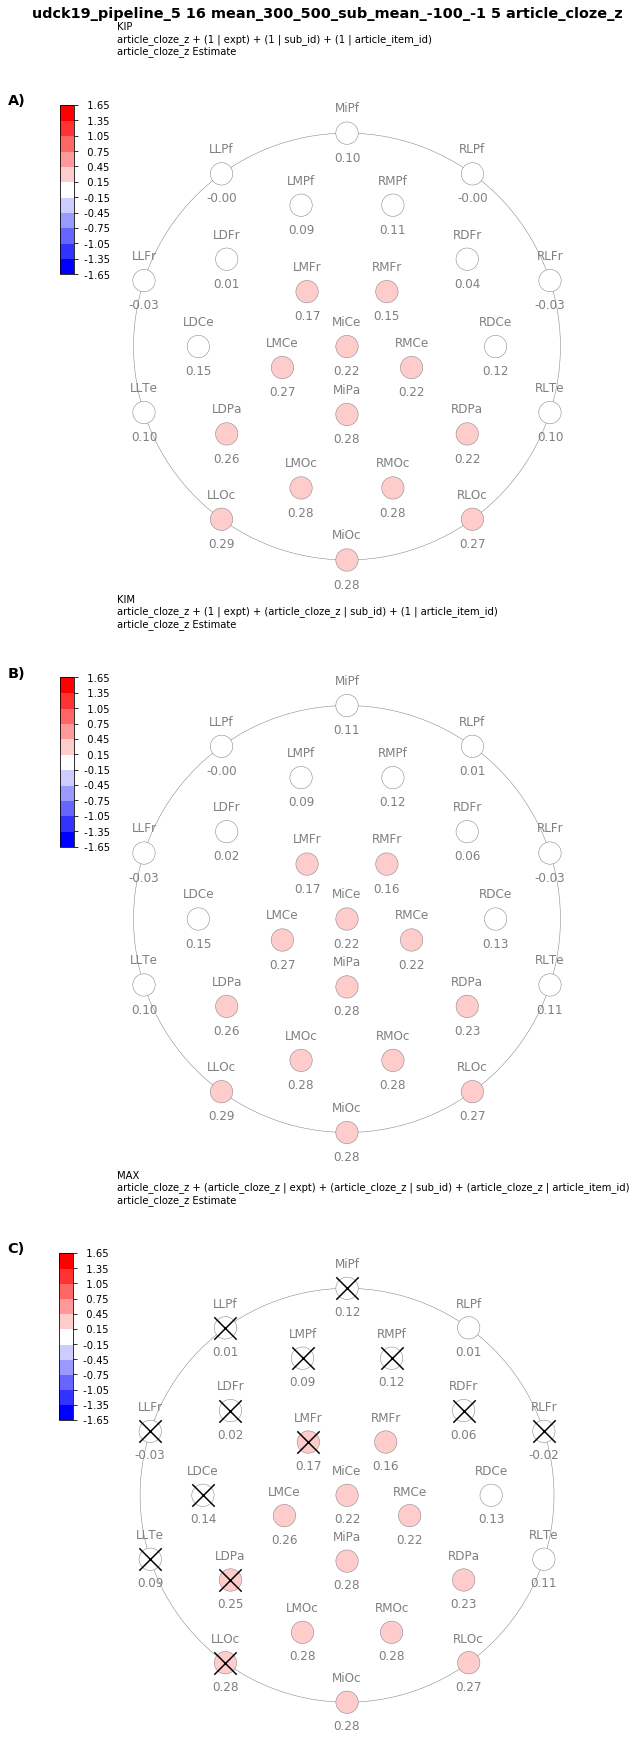

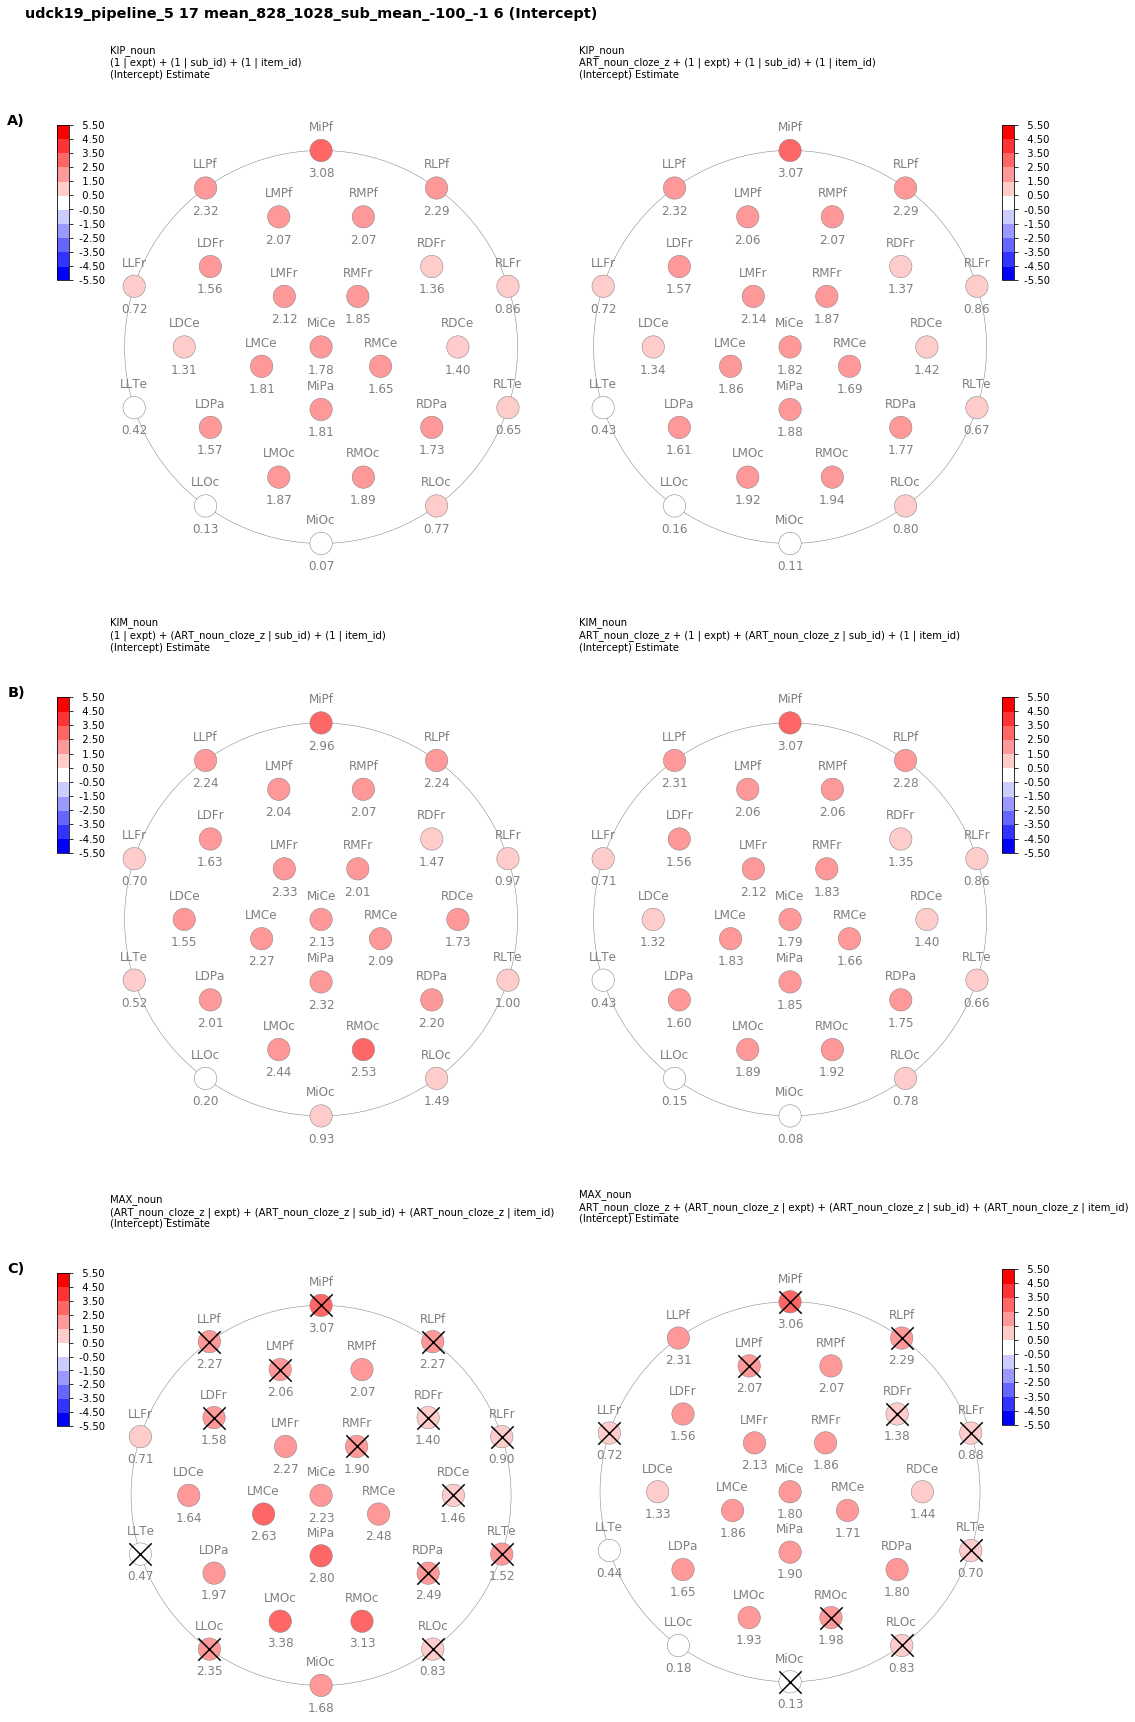

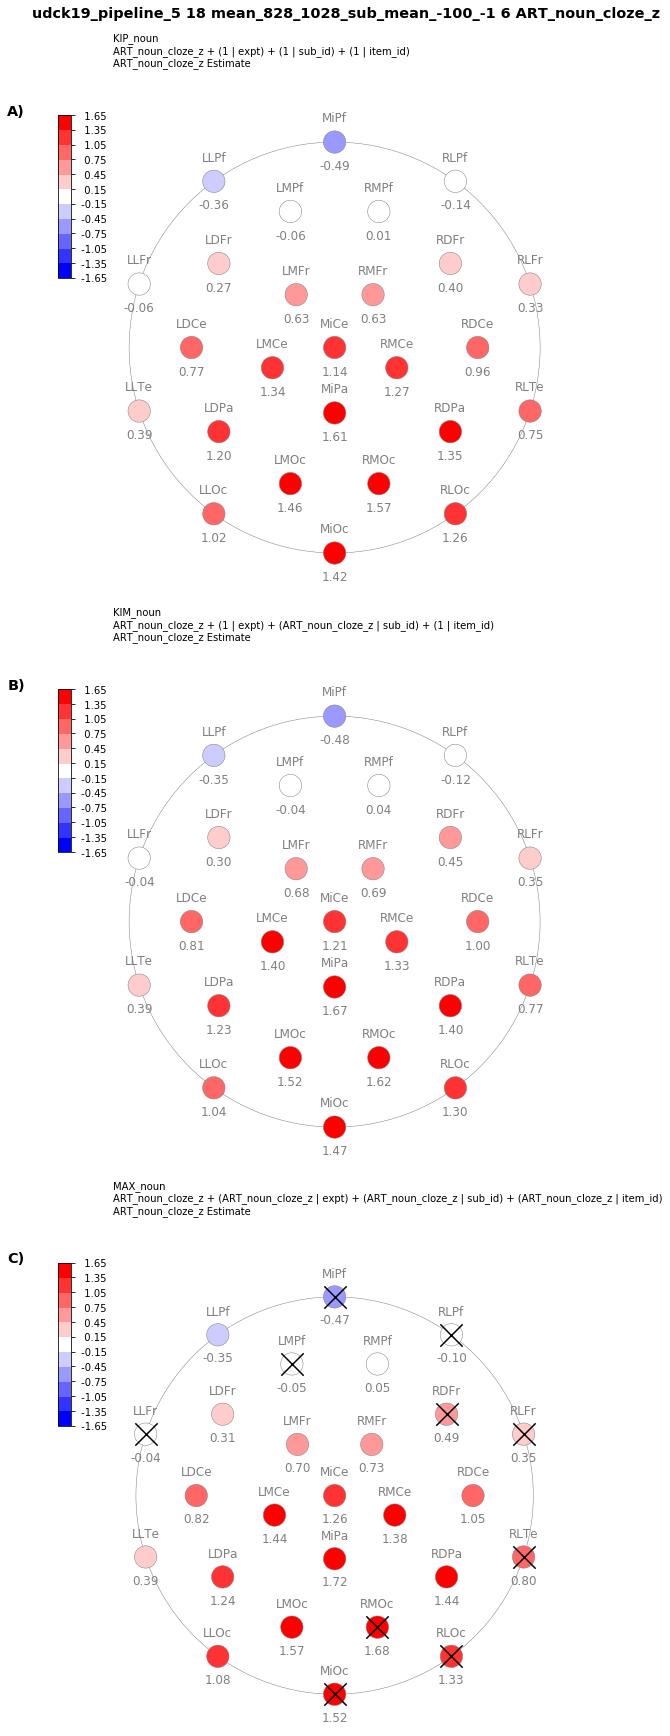

In [18]:
plt.close('all')

hcmp_kws = dict(
    edgecolor='gray',
    lw=0.5,
    s=500
    
)

data_col='Estimate'
x_col, y_col = 'x_lambert', 'y_lambert'
cmap_ = 'bwr'

plt.close('all')
for (interval, measure, beta), comp_data in data_df.groupby(['Time', 'measure', 'beta']):

    comps_keys = [key for key in comp_data.index.unique('proc') if "x_expt" not in key]

    n_rows = len(comps_keys)
    if n_rows == 0:
        continue

    f = plt.figure(figsize=(16, 8 * n_rows))
    fig_tag = f"{FIG_PREFIX} {FIG_COUNT} {measure} {interval} {beta}"
    f.suptitle(fig_tag, **FIG_TAG_SPECS)

    panel_idx = 0
    for row, proc in enumerate(comps_keys):

        # ------------------
        # data by channel
        # ------------------

        for aix, (model, plot_data) in enumerate(
            comp_data.query('proc==@proc').groupby('model') 
        ):
            #print(aix, interval, measure, beta, proc, model)
            #print(plot_data.size)
            #print()
            #print(plot_data.head())

            ax = f.add_subplot(
                n_rows,
                2, 
                1 + (row * 2) + aix,
                aspect='equal',
            )
            ax.axis('off')
            
            # if there's no data move along to the next one
            if plot_data.size == 0:
                continue
                
            # set the channel location coordinates at run time
            pdat = plot_data.merge(
                CAP26_DF,
                how='inner',
                left_index=True, 
                right_index=True
            ).reset_index('channel')
            
            # colorbar
            if beta == '(Intercept)':
                # head_cmap, head_norm = get_symdiv_cmap_norm(cmap_, -4.5, 4.5, 4)
                head_cmap, head_norm = get_symdiv_cmap_norm(cmap_, -5.5, 5.5, 5)
            else:
                #head_cmap, head_norm = get_symdiv_cmap_norm(cmap_, -1.1, 1.1, 5)
                head_cmap, head_norm = get_symdiv_cmap_norm(cmap_, -1.65, 1.65, 5)
            
            
            hcmp_kws['cmap'], hcmp_kws['norm'] = head_cmap, head_norm
 
            sm = mpl.cm.ScalarMappable(norm=head_norm, cmap=head_cmap)
            sm.set_array(pdat[data_col])
        
            sgn = (aix % 2) - 1  # left/right cbar location
            cax = ax.inset_axes([ aix + (sgn *.125), 0.65, 0.03, 0.35])
            cb = ax.figure.colorbar(
                sm, 
                cax=cax, 
                format="%6.2f", 
                panchor=False, 
                ticks=head_norm.boundaries
            )
             
            scatter = ax.scatter(
                x=pdat[x_col],
                y=pdat[y_col],
                c=pdat[data_col],
                **hcmp_kws,
            )


            #  circle
            circ_kws=dict(
                facecolor='none', edgecolor='gray', lw=0.5, clip_on=False, zorder=0.1
            )
            circ = mpl.patches.Circle(
                (0.0, 0.0),
                radius=1.0,
            **circ_kws,
            )
            ax.add_patch(circ)                       

            # axis title-like
            ax.text(
                x=0, 
                y=1.1,
                s= f"{proc}\n{model}\n{beta} {data_col}",
                ha='left', 
                va='bottom',
                transform=ax.transAxes
            )
    
            # set panel label per row
            if aix == 0:
                ax.text(
                    x=-0.2,
                    y=1.0,
                    s=f"{panel_from_idx(panel_idx)})",
                    **panel_kws,
                    transform=ax.transAxes
                )
             
            # -----------
            # decorations
            # -----------
            
            # channel labels
            pdat.apply(
                lambda r: ax.text(
                    x=r[x_col], 
                    y=r[y_col] + (.075 * ax.get_ylim()[1]), # nudge up
                    s=r['channel'],
                    **chan_label_kws
                ),
                1
            )
            
            # data values
            pdat.apply(
                lambda r: ax.text(
                    x=r[x_col], 
                    y=r[y_col] - (.075 * ax.get_ylim()[1]), # nudge down
                    s=f"{r[data_col]:3.2f}",
                    ha="center",
                    va="top",
                    fontsize="large",
                    color='gray'
                ),
                1
            )
            
            # warnings
            wrns = pdat[pdat['has_warning'] == 1.0]
            wrns.apply(
                lambda r:
                ax.scatter(
                    x=r[x_col], y=r[y_col], c='black', s=500, marker='x'
                ), 
                1
            )

        panel_idx += 1
    f.tight_layout()
    FIG_COUNT = udck19_figsave(f, fig_tag, FIG_COUNT)
    

In [19]:
# log execution time
pipeline_stop = datetime.datetime.now()

elapsed =  pipeline_stop - pipeline_start
LOGGER.info(f"""
Done {pipeline_stop.strftime("%d.%b %Y %H:%M:%S")}
Elapsed time: {elapsed}
""")


udck19_pipeline_5.ipynb:INFO:
Done 29.Oct 2019 07:54:44
Elapsed time: 1:07:16.588998

